In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download data 
We choose this site https://mesonet.agron.iastate.edu/request/download.phtml?network=FR__ASOS <br>

From that site we manually get all weather stations of:
- Austria  
- Belgium  
- Croatia  
- Czech Republic  
- France  
- Germany  
- Italy  
- Luxembourg  
- Netherlands  
- Switzerland  
 

## Merge all Station datasets and filter by date and coordinates
Then we look for stations in a specific geographic area and between 1980-2025

In [26]:
station_files = os.path.join(os.getcwd(), "datasets", "stations")
df_combined = None
for file in os.listdir(station_files):
    df = pd.read_csv(os.path.join(station_files, file), engine='c')
    if df_combined is not None:
        df_combined = pd.concat([df_combined, df], ignore_index=True)
    else:
        df_combined = df
        
        
df_combined["endts"] = df_combined['endts'].fillna('2025-02-21 00:00')

df_combined['begints'] = pd.to_datetime(df_combined['begints'])
df_combined['endts'] = pd.to_datetime(df_combined['endts'])

start_date = pd.to_datetime("1980-01-01")
end_date = pd.to_datetime("2025-02-21")

df_combined = df_combined[(df_combined['begints'] <= start_date) & (df_combined['endts'] == end_date)]

min_lat, max_lat = 42, 49.0
min_lon, max_lon = 5.0, 16.0 
stations_dataset = df_combined[(df_combined['lat'] >= min_lat) & (df_combined['lat'] <= max_lat) & 
                 (df_combined['lon'] >= min_lon) & (df_combined['lon'] <= max_lon)]

stations_dataset.to_csv("stations.csv", index=False)

In [12]:
import iowa_API

def make_query(stationid):
    return f"station={stationid}&data=all&year1=1980&month1=1&day1=1&year2=2025&month2=2&day2=22&tz=Etc%2FUTC&format=onlycomma&latlon=yes&elev=yes&missing=null&trace=null&direct=no&report_type=3"

# for stid in stations_dataset['stid'].unique():
#     iowa_API.get_data_from_query(make_query(stid), station=stid, pathtosave=os.path.join(os.getcwd(), "datasets", "raw-datasets-txt"))

## Draw Stations in map 
A image reference can be found under /resources/images/stations-on-maps.png. This because Palantir does not let to download the background with contextily. For short, here it is.

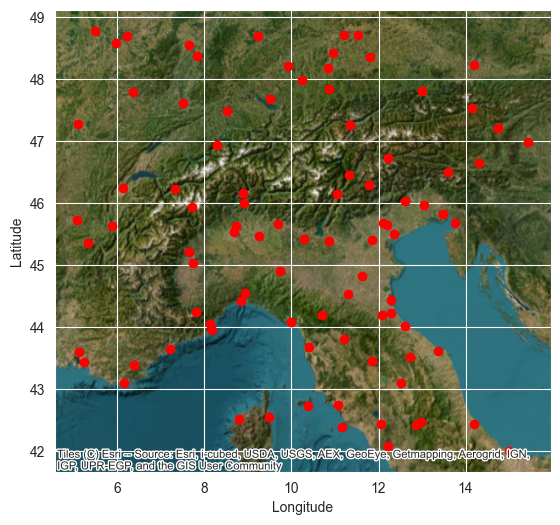

In [50]:
from PIL import Image
try:
    img = Image.open("./resources/images/stations-on-maps.png")
    display(img)
except Exception:
    pass

The following code has been used to genereate the previous image

In [49]:
# import geopandas as gpd
# from shapely.geometry import Point
# import contextily as ctx
# 
# stations_df = pd.read_csv("stations.csv")
# gdf = gpd.GeoDataFrame(stations_df, geometry=gpd.points_from_xy(stations_df.lon, stations_df.lat), crs="EPSG:4326")
# 
# gdf_basemap = gdf.to_crs(epsg=4326)
# 
# fig, ax = plt.subplots(figsize=(10, 6))
# 
# gdf.plot(ax=ax, marker='o', label="Stations", color="red")
# 
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf_basemap.crs)
# 
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

# Data Preparation

In [17]:
def convert_column(column: pd.Series, factor: float) -> pd.Series:
    try:
        column = column.astype(float) * factor
    except ValueError:
        column = pd.to_numeric(column, errors='coerce')
        column = column.astype(float) * factor
    return column

Reference for Cloud Cover Abbreviations:
* "BKN" : "Broken cloud layer 5/8ths to 7/8ths"
* "CB": "Cumulonimbus"
* "CLR": "Sky clear at or below 12,000 feet above ground level (AGL)"
* "FEW": "Few cloud layer 0/8ths to 2/8ths"
* "OVC": "Overcast cloud layer 8/8ths coverage"
* "SCT": "Scattered cloud layer 3/8ths to 4/8ths"
* "SKC": "Sky Clear"
* "TCU": "Towering Cumulus"

Got from http://www.moratech.com/aviation/metaf-abbrev.html

The following code is used to convert all feature dimensions in S.I dimensions

In [180]:
# for file in os.listdir(os.path.join(os.getcwd(), "datasets", "raw-datasets-txt")):
#     if ".txt" in file:
#         print(f"Working with {file}")
#         df = pd.read_csv(os.path.join(os.getcwd(), "datasets", "raw-datasets-txt", file), low_memory=False)
# 
#         df['valid'] = pd.to_datetime(df['valid'])
# 
#         df['tmpf'] = (df['tmpf'].astype(float) - 32) * 5/9 # from °F to °C
#         df['feel'] = (df['feel'].astype(float) - 32) * 5/9 # from °F to °C
# 
#         for feature in ["elevation", "skyl1", "skyl2", "skyl3", "skyl4"]:
#             df[feature] = convert_column(df[feature], factor=0.3048) # from feet to meters
# 
#         # drct is wind direction in degrees from true north (0° = North, 90° = East, 180° = South, 270° = West)
#         # elevation is above sea level
# 
#         for feature in ["sknt", "gust", 'peak_wind_gust']:
#             df[feature] = convert_column(df[feature], factor=0.514444) # from knots to m/s
# 
# 
#         df['p01i'] = convert_column(df['p01i'], factor=0.0254) # from inches to meters
#         df['mslp'] = convert_column(df['mslp'], factor=100) # from millibar to Pascal
#         df['vsby'] = convert_column(df['vsby'], factor=1.60934) # from miles to Kilometers
# 
#         for feature in ["skyc1", "skyc2", "skyc3", "skyc4"]:
#             df[feature] = df[feature].replace('   ', 'CLR')
# 
#         df.columns = ["station", "timestamp", "lon", "lat", "elevation", "temperature", "dew_point", "relative_humidity", "wind_direction",
#                       "wind_speed", "precipitaion_1hr", "altitude", "mean_sea_level_pressure", "visibility", "wind_gust", "first_cloud_layer_cover",
#                       "second_cloud_layer_cover", "third_cloud_layer_cover", "fourth_cloud_layer_cover", "first_cloud_layer_height", 
#                       "second_cloud_layer_height", "third_cloud_layer_height", "fourth_cloud_layer_height", "weather_condition",
#                       'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_direction',
#                       'peak_wind_time', "feel_temperature", "raw_metar", "snowdepth"]

        # df.to_csv(os.path.join(os.getcwd(), "datasets", "raw-datasets-csv", file.replace('.txt', '.csv')), index=False)

# Missing Values
### Remove all columns having all nan values

In [74]:
def get_all_nan_columns(df):
    return set(df.columns[df.isna().all()])  

In [4]:
stations = pd.read_csv("stations.csv", engine='c')["stid"].unique()
current_wdir = os.path.join(os.getcwd(), 'datasets', 'raw-datasets-csv')
dataset_results = {}

for index, station in enumerate(stations):
    df = pd.read_csv(os.path.join(current_wdir, station + ".csv"), engine='c', low_memory=False)

    nan_columns = get_all_nan_columns(df)
    dataset_results[station] = nan_columns
    # print(set.intersection(*dataset_results.values()), station, index+1)

common_nan_columns = set.intersection(*dataset_results.values())

In [3]:
current_wdir = os.path.join(os.getcwd(), 'datasets')
for index, station in enumerate(stations):
    df = pd.read_csv(os.path.join(current_wdir, 'raw-datasets-csv', station + ".csv"), engine='c', low_memory=False)
    df = df.drop(columns=list(common_nan_columns))
    df.to_csv(os.path.join(current_wdir, "removed-nan-csv", station + ".csv"), index=False)

### Working with NaN

We noticed there are some missing days in our datasets and in some datasets these missing days become a lot. We decided to handle only datasets which less than 500 consecutive days missing. So we will work with 61% of our downloaded datasets. For these datasets we are going to impute missing values.
<br>
The following code let us to undertand how many days are missing for each dataset.

In [114]:
# current_wdir = os.path.join(os.getcwd(), 'datasets', "removed-nan-csv")
# results = []
# 
# for file in os.listdir(current_wdir):
#     df = pd.read_csv(os.path.join(current_wdir, file), parse_dates=["timestamp"], low_memory=False)
#     df = df.sort_values(by="timestamp")
#     df["date"] = df["timestamp"]
#     df = df.groupby(df["date"].dt.date).count()
#     df.index = pd.to_datetime(df.index)
#     df["time_diff"] = df.index.to_series().diff().dt.days  
# 
#     max_delta_days_missing = "No days missing" if df["time_diff"].empty or df["time_diff"].isna().all() else df["time_diff"].max()
#     df.drop("date", axis=1, inplace=True)
#     df = df.reset_index()
#     min_date_available = df["date"].dt.date.min()
#     
#     print((file, max_delta_days_missing, min_date_available))
#     results.append((file, max_delta_days_missing, min_date_available))

('EDDM.csv', 445.0, datetime.date(1980, 1, 1))
('EDDS.csv', 2656.0, datetime.date(1980, 1, 1))
('EDJA.csv', 1711.0, datetime.date(1980, 1, 1))
('EDMA.csv', 2664.0, datetime.date(1980, 1, 1))
('EDNY.csv', 609.0, datetime.date(1980, 2, 26))
('EDTL.csv', 458.0, datetime.date(1980, 1, 1))
('ETHA.csv', 1527.0, datetime.date(1980, 1, 2))
('ETHL.csv', 59.0, datetime.date(1980, 1, 2))
('ETSI.csv', 55.0, datetime.date(1980, 1, 2))
('ETSL.csv', 14.0, datetime.date(1980, 1, 1))
('ETSN.csv', 31.0, datetime.date(1980, 1, 1))
('LFKB.csv', 23.0, datetime.date(1980, 1, 1))
('LFKC.csv', 23.0, datetime.date(1980, 1, 2))
('LFLB.csv', 24.0, datetime.date(1980, 1, 1))
('LFLL.csv', 38.0, datetime.date(1980, 1, 1))
('LFLS.csv', 27.0, datetime.date(1980, 1, 1))
('LFMC.csv', 375.0, datetime.date(1980, 1, 1))
('LFML.csv', 26.0, datetime.date(1980, 1, 1))
('LFMN.csv', 35.0, datetime.date(1980, 1, 1))
('LFMY.csv', 581.0, datetime.date(1980, 1, 1))
('LFSB.csv', 23.0, datetime.date(1980, 1, 1))
('LFSD.csv', 13.0, d

The following code shows us the one that has less than 500 consecutive days missing and minimum date of 1981-01-01

In [133]:
# datasets_to_impute = []
# for index, (file, max_delta_days_missing, min_date_available) in enumerate(results):
#     if max_delta_days_missing <= 500 and min_date_available <= pd.to_datetime("1981-01-01").date():
#         print(results[index])
#         datasets_to_impute.append(file)
# with open(os.path.join(os.getcwd(), "datasets", "best-datasets.csv"), "w") as file:
#     for row in datasets_to_impute:
#         file.write(f"{row}\n")
# print(f"We have the {len(datasets_to_impute)/len(results)*100: .2f} of the original number of downloaded datasets")

('EDDM.csv', 445.0, datetime.date(1980, 1, 1))
('EDTL.csv', 458.0, datetime.date(1980, 1, 1))
('ETHL.csv', 59.0, datetime.date(1980, 1, 2))
('ETSI.csv', 55.0, datetime.date(1980, 1, 2))
('ETSL.csv', 14.0, datetime.date(1980, 1, 1))
('ETSN.csv', 31.0, datetime.date(1980, 1, 1))
('LFKB.csv', 23.0, datetime.date(1980, 1, 1))
('LFKC.csv', 23.0, datetime.date(1980, 1, 2))
('LFLB.csv', 24.0, datetime.date(1980, 1, 1))
('LFLL.csv', 38.0, datetime.date(1980, 1, 1))
('LFLS.csv', 27.0, datetime.date(1980, 1, 1))
('LFMC.csv', 375.0, datetime.date(1980, 1, 1))
('LFML.csv', 26.0, datetime.date(1980, 1, 1))
('LFMN.csv', 35.0, datetime.date(1980, 1, 1))
('LFSB.csv', 23.0, datetime.date(1980, 1, 1))
('LFSD.csv', 13.0, datetime.date(1980, 1, 1))
('LFSO.csv', 73.0, datetime.date(1980, 1, 1))
('LFST.csv', 3.0, datetime.date(1980, 1, 1))
('LFSX.csv', 73.0, datetime.date(1980, 1, 1))
('LFTH.csv', 12.0, datetime.date(1980, 1, 1))
('LIBP.csv', 15.0, datetime.date(1980, 1, 1))
('LIMC.csv', 8.0, datetime.date(

## Imputation 

In [4]:
from sklearn.impute import KNNImputer

In [135]:
# For correct cast our columns
dtype_dict = {
    "station": "object",
    "timestamp": "datetime64[ns]",
    "lon": "float64",
    "lat": "float64",
    "elevation": "float64",
    "temperature": "float64",
    "dew_point": "float64",
    "relative_humidity": "float64",
    "wind_direction": "float64",
    "wind_speed": "float64",
    "precipitaion_1hr": "float64",
    "altitude": "float64",
    "visibility": "float64",
    "wind_gust": "float64",
    "feel_temperature": "float64",
}

For each dataset we are going to do imputation, we have done some tries with one dataset at time but here we do the procedure for all of them. Furthermore we are going to ensemble all these single datasets in a big one.

In particular, for each dataset we do the following:<br>
* Remove useless features (most of them categorical)
* Take a part only numeric columns and the station id
* Then we aggregate by date and apply the mean
* Since, as discussed before, there are some missing dates, we generate a list of dates between 1981-01-01 to 2025-02-21
* Insert the missing dates in our aggregate dataframe and fill the row with NaN values for all the columns
* Impute that missing values using KNNImputer
* Finally we rebuild from the imputed_df the original dataframe structure with dtypes and column names

Here is the code

In [139]:
# current_wdir = os.path.join(os.getcwd(), 'datasets', 'removed-nan-csv')
# for dataset in datasets_to_impute:
#     df = pd.read_csv(os.path.join(current_wdir, dataset), engine='c', low_memory=False) #, parse_dates=['timestamp'], index_col='timestamp')
#     df.drop(["raw_metar", "weather_condition", "first_cloud_layer_cover", 
#              "second_cloud_layer_cover", "third_cloud_layer_cover", "fourth_cloud_layer_cover",
#              "first_cloud_layer_height", "second_cloud_layer_height", "third_cloud_layer_height",
#              "fourth_cloud_layer_height", "mean_sea_level_pressure"], axis=1, inplace=True)
#     
#     df["timestamp"] = pd.to_datetime(df["timestamp"])
#     df = df.astype(dtype_dict)
#     df['date'] = df['timestamp'].dt.date
#     
#     
#     numeric_columns = df.select_dtypes(include=['number']).columns
#     date_range = pd.date_range(start='1980-01-01', end='2025-02-21')
#     
#     filtered_df = df[numeric_columns].copy()
#     filtered_df['date'] = df['date']
#     filtered_df_aggregate = filtered_df.groupby('date').mean()
#     final_filtered = filtered_df_aggregate.reindex(date_range, fill_value=None)
#     
#     print(dataset)
#     
#     imputer = KNNImputer(n_neighbors=10)
#     imputed_df = imputer.fit_transform(final_filtered)
#     
#     imputed_df = pd.DataFrame(imputed_df, columns=final_filtered.columns)
#     imputed_df.index = date_range
#     imputed_df['station'] = dataset.replace(".csv", "")
#     imputed_df['timestamp'] = date_range
#     imputed_df = imputed_df.astype(dtype_dict)
#     imputed_df.to_csv(os.path.join(os.getcwd(), "datasets", "clean-csv", dataset))
#     
#     del imputed_df, df, final_filtered, date_range, imputer, filtered_df, filtered_df_aggregate

EDDM.csv
EDTL.csv
ETHL.csv
ETSI.csv
ETSL.csv
ETSN.csv
LFKB.csv
LFKC.csv
LFLB.csv
LFLL.csv
LFLS.csv
LFMC.csv
LFML.csv
LFMN.csv
LFSB.csv
LFSD.csv
LFSO.csv
LFST.csv
LFSX.csv
LFTH.csv
LIBP.csv
LIMC.csv
LIME.csv
LIMJ.csv
LIML.csv
LIMN.csv
LIMS.csv
LIMU.csv
LIMV.csv
LIMY.csv
LIPA.csv
LIPB.csv
LIPC.csv
LIPE.csv
LIPI.csv
LIPK.csv
LIPY.csv
LIPZ.csv
LIQO.csv
LIRQ.csv
LIRS.csv
LIRV.csv
LIVC.csv
LIVD.csv
LIVP.csv
LIVR.csv
LOWG.csv
LOWI.csv
LOWK.csv
LOWL.csv
LOWS.csv
LOXZ.csv
LSGG.csv
LSGS.csv
LSZA.csv
LSZH.csv


Ensable all the datasets into a unique one

In [2]:
current_wdir = os.path.join(os.getcwd(), 'datasets', 'clean-csv')
datasets_to_impute = []
with open(os.path.join(os.getcwd(), "datasets", "best-datasets.csv"), "r") as file:
    for row in file.readlines():
        datasets_to_impute.append(row.strip())
big_dataset = None
for file in datasets_to_impute:
    if big_dataset is not None:
        df = pd.read_csv(os.path.join(current_wdir, file), engine='c', low_memory=False)
        big_dataset = pd.concat([big_dataset, df], ignore_index=True)
    else:
        df = pd.read_csv(os.path.join(current_wdir, file), engine='c', low_memory=False)
        big_dataset = df.copy()
big_dataset.reset_index(drop=True, inplace=True)
big_dataset.drop('Unnamed: 0', inplace=True, axis=1)
big_dataset["timestamp"] = pd.to_datetime(big_dataset["timestamp"])
big_dataset["year"] = big_dataset["timestamp"].dt.year
big_dataset["month"] = big_dataset["timestamp"].dt.strftime("%B")
big_dataset["day"] = big_dataset["timestamp"].dt.day
big_dataset.to_csv("big_dataset.csv", index=False)

# Data Analysis

Base on what we read in this [paper](https://link.springer.com/article/10.1007/s00382-022-06303-3), we decide to divide our stations into three groups: south, north-west and north-east. In particular we see the regions in the paper and tryed to replicate them in our case. Furthermore we watch out about number of stations between north-west and north-east by following this approach:
* South Region if latitutde <= 46.25
* North-West Region if longitude <= 11 and latitutde > 46
* North-East Region if longitude > 11 and latitude > 46
<br>
The following code shows the stations for each sub-region.

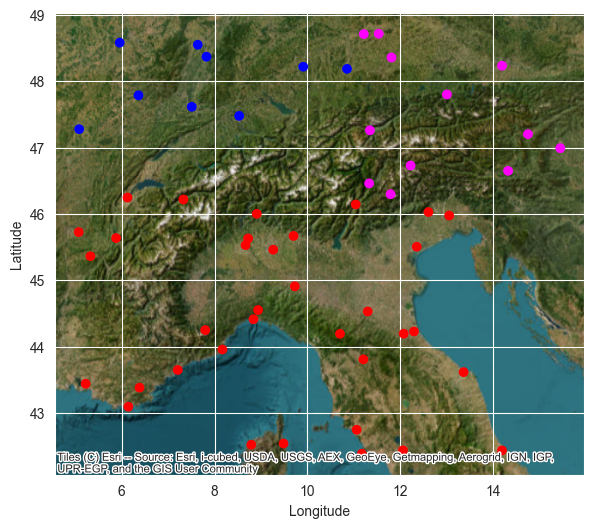

In [342]:
from PIL import Image
try:
    img = Image.open("./resources/images/stations-per-region.png")
    display(img)
except Exception:
    pass

The following code has been used to genereate the previous image

In [343]:
# import geopandas as gpd
# from shapely.geometry import Point
# import contextily as ctx
# 
# stations_df = pd.read_csv("stations.csv")
# datasets_imputed = []
# with open(os.path.join(os.getcwd(), "datasets", "best-datasets.csv"), "r") as file:
#     for row in file.readlines():
#         datasets_imputed.append(row.strip().replace(".csv", ""))
#         
# filtered_stations = stations_df[stations_df.iloc[:, 0].astype(str).isin(datasets_imputed)]
#         
# gdf = gpd.GeoDataFrame(filtered_stations, geometry=gpd.points_from_xy(filtered_stations.lon, filtered_stations.lat), crs="EPSG:4326")
# 
# gdf_basemap = gdf.to_crs(epsg=4326)
# 
# colors = []
# for lat, lon in zip(gdf.lat, gdf.lon):
#     
#     if lon <= 11:
#         color = "blue"
#     else:
#         color = "magenta"
#         
#     if lat <= 46.25:
#         color = "red"
#         
#     colors.append(color)
# 
# fig, ax = plt.subplots(figsize=(10, 6))
# 
# gdf.plot(ax=ax, color=colors, marker='o', label="Stations")
# 
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf_basemap.crs)
# 
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

Assign to each stations its region

In [52]:
def assign_location_region(lat, lon):
    if lat <= 46.25:
        return "S"
    elif lon <= 11 and lat > 46:
        return "NW"
    elif lon > 11 and lat > 46:
        return "NE"
big_dataset = pd.read_csv("big_dataset.csv", engine='c', low_memory=False)   
big_dataset['region'] = big_dataset.apply(lambda row: assign_location_region(row['lat'], row['lon']), axis=1)

Always base on what we read in the paper, we discover that regions at different elevations have different behaviours. So we analyze the cumulative distribution function of *elevation* for the region S, which is the region where our Valley are located. In particular we count how many values in elevation are ≤ each unique elevation value.

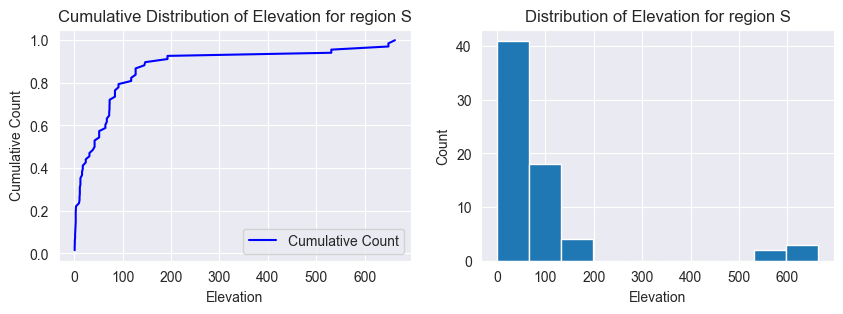

In [369]:
elevation = big_dataset[big_dataset["region"] == "S"][["station", "elevation"]].drop_duplicates()["elevation"].to_numpy()

unique_elevations = np.sort(np.unique(elevation))

cumulata = np.searchsorted(np.sort(elevation), unique_elevations, side="right")

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(unique_elevations, cumulata/cumulata.max(), linestyle="-", color="b", label="Cumulative Count")
plt.xlabel("Elevation")
plt.ylabel("Cumulative Count")
plt.title("Cumulative Distribution of Elevation for region S")
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
elevation = big_dataset[big_dataset["region"] == "S"][["station", "elevation"]].drop_duplicates()["elevation"]
plt.hist(elevation)
plt.title(f"Distribution of Elevation for region S")
plt.xlabel("Elevation")
plt.ylabel("Count")
plt.show()

We decide to create a further division base on elevation. We create three groups, each one has the 33% of the stations.

In [370]:
cumulate_array = np.stack((unique_elevations, cumulata/cumulata.max()), axis=1)
targets = np.array([0, 0.33, 0.66, 1])
closest_values = [cumulate_array[np.abs(cumulate_array[:, 1] - target).argmin(), 0] for target in targets]
elevation_category = {
    f"H{i+1}": (closest_values[i], closest_values[i+1])
    for i in range(len(closest_values) - 1)
}
elevation_category

{'H1': (0.9144, 12.8016),
 'H2': (12.8016, 72.23760000000003),
 'H3': (72.23760000000003, 662.3304)}

We do the same for the North-West and North-East regions.

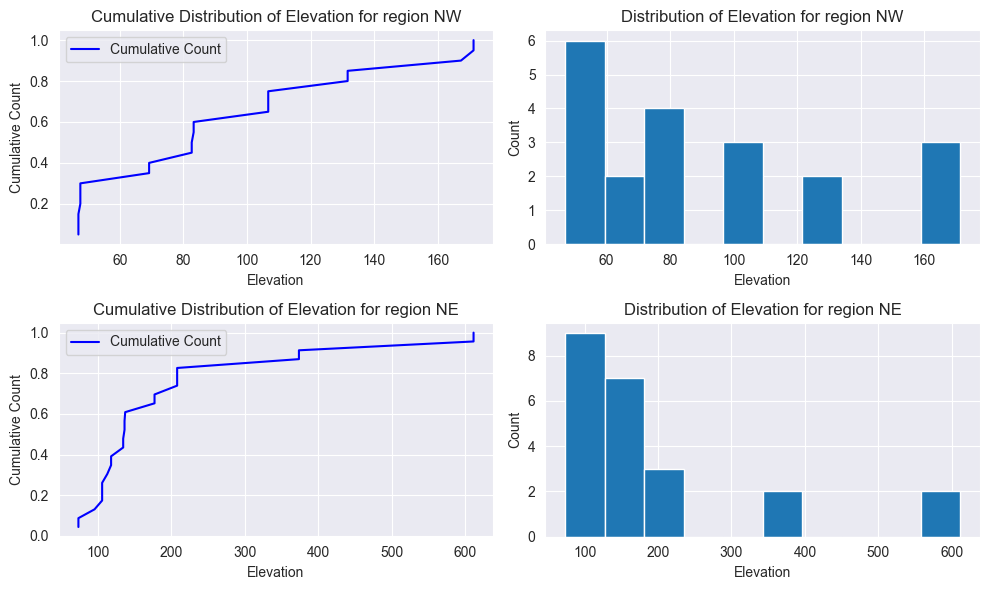

In [371]:
elevation_cat_for_region = {}
elevation_cat_for_region["S"] = elevation_category

plt.figure(figsize=(10, 6))
for index, region in enumerate(["NW", "NE"]):
    elevation = big_dataset[big_dataset["region"] == region][["station", "elevation"]].drop_duplicates()["elevation"].to_numpy()
    
    unique_elevations = np.sort(np.unique(elevation))
    
    cumulata = np.searchsorted(np.sort(elevation), unique_elevations, side="right")
    cumulate_array = np.stack((unique_elevations, cumulata/cumulata.max()), axis=1)
    
    targets = np.array([0, 0.33, 0.66, 1])
    closest_values = [cumulate_array[np.abs(cumulate_array[:, 1] - target).argmin(), 0] for target in targets]
    
    elevation_cat_for_region[region] = {
                                        f"H{i+1}": (closest_values[i], closest_values[i+1])
                                        for i in range(len(closest_values) - 1)
                                        }
    
    plt.subplot(2, 2, 1+(2*index))
    
    plt.plot(unique_elevations, cumulata/cumulata.max(), linestyle="-", color="b", label="Cumulative Count")
    plt.xlabel("Elevation")
    plt.ylabel("Cumulative Count")
    plt.title(f"Cumulative Distribution of Elevation for region {region}")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2*(index+1))
    elevation = big_dataset[big_dataset["region"] == region][["station", "elevation"]].drop_duplicates()["elevation"]
    plt.hist(elevation)
    plt.title(f"Distribution of Elevation for region {region}")
    plt.xlabel("Elevation")
    plt.ylabel("Count")
    
plt.tight_layout()
plt.show()

Unfortunately here we have not so much data as before for three eventually categories. We choose to assign a label to region S for different elevation group. For the other regions we assing "H0" just for not leave it empty

In [51]:
def assign_elevation_group(elev, region):
    if region == "S":
        for category, (low, high) in elevation_cat_for_region[region].items():
            if low <= elev <= high:
                return category
    return "H0"

In [366]:
big_dataset['elevation_group'] = big_dataset.apply(lambda row: assign_elevation_group(row['elevation'], row["region"]), axis=1)
big_dataset.to_csv("climate_clean.csv", index=False)

Here we load our new dataset with the new features.

In [2]:
main_df = pd.read_csv("climate_clean.csv", engine='c', low_memory=False)
season_mapping = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Autumn', 'October': 'Autumn', 'November': 'Autumn'
}

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
main_df['season'] = main_df['month'].map(season_mapping)


So far we have our clean dataset with our new features --> ["elevation_group", "region", "season"]
These new features let us to reduce heterogeneity and discover new correlations

# Outliers Detection

Before going further we are going to considerate only some features, this because in the other features we noticed a massive precence of outliers maybe due to bad measuraments by instruments. For this groups of features we look for their distributions.

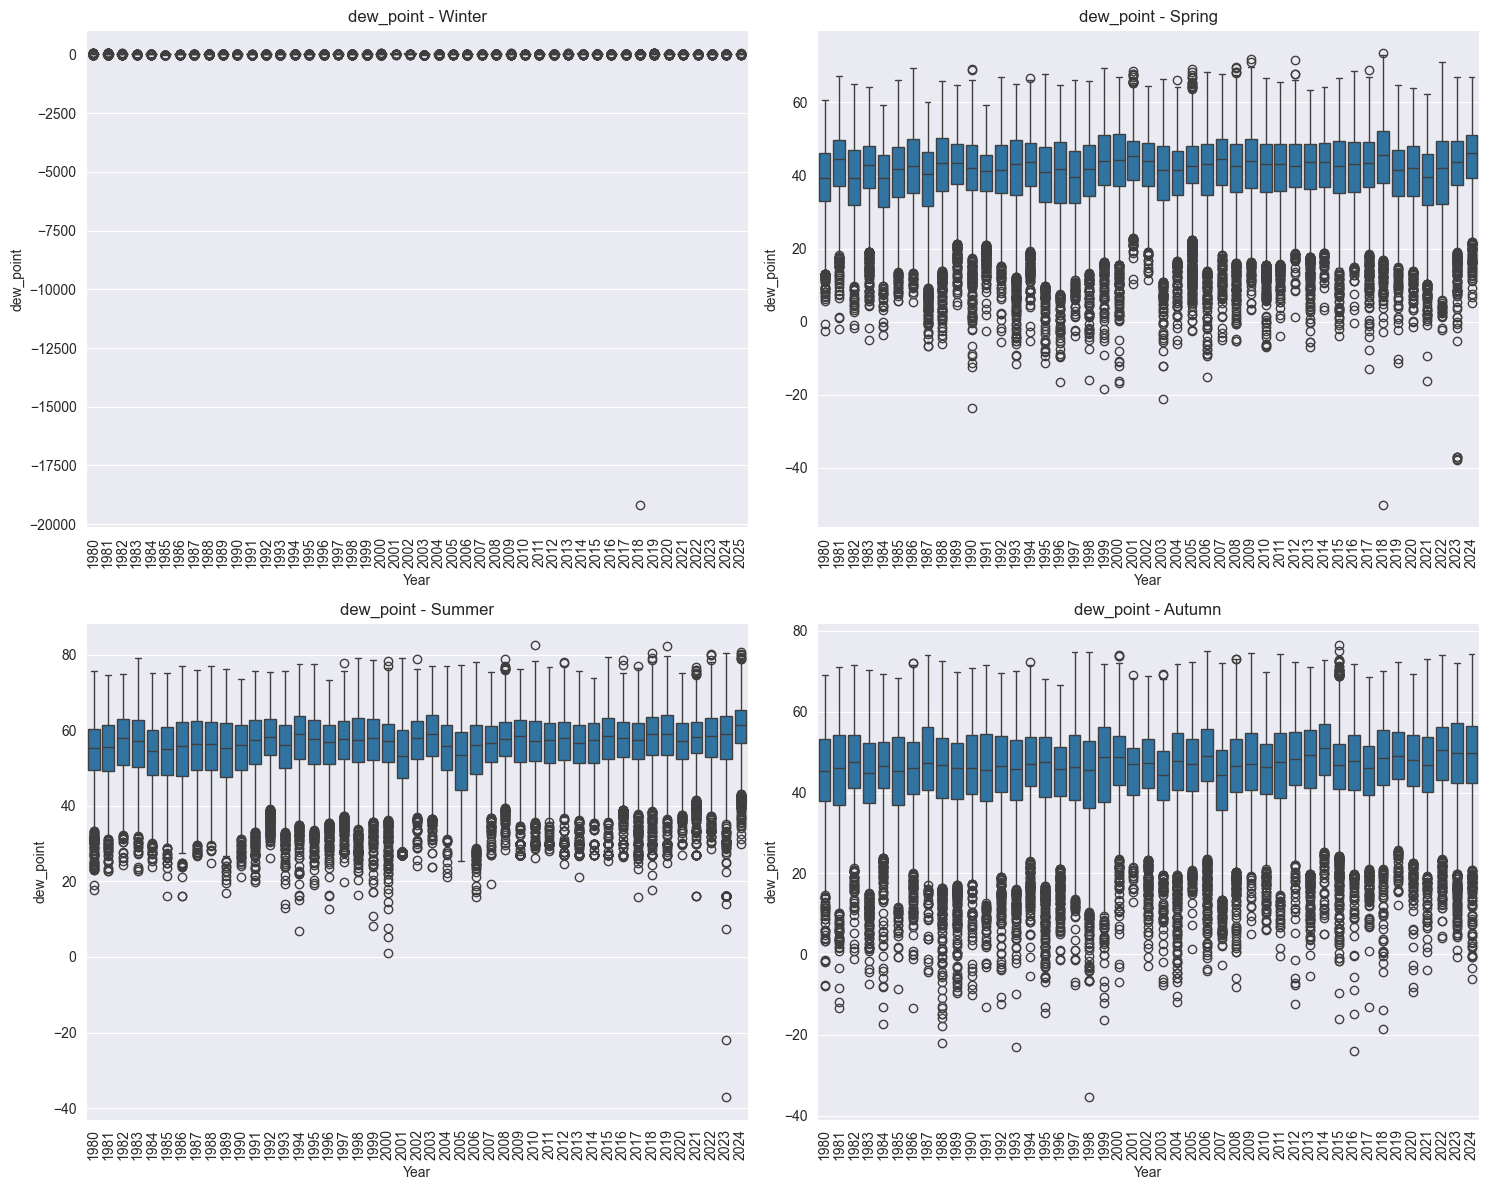

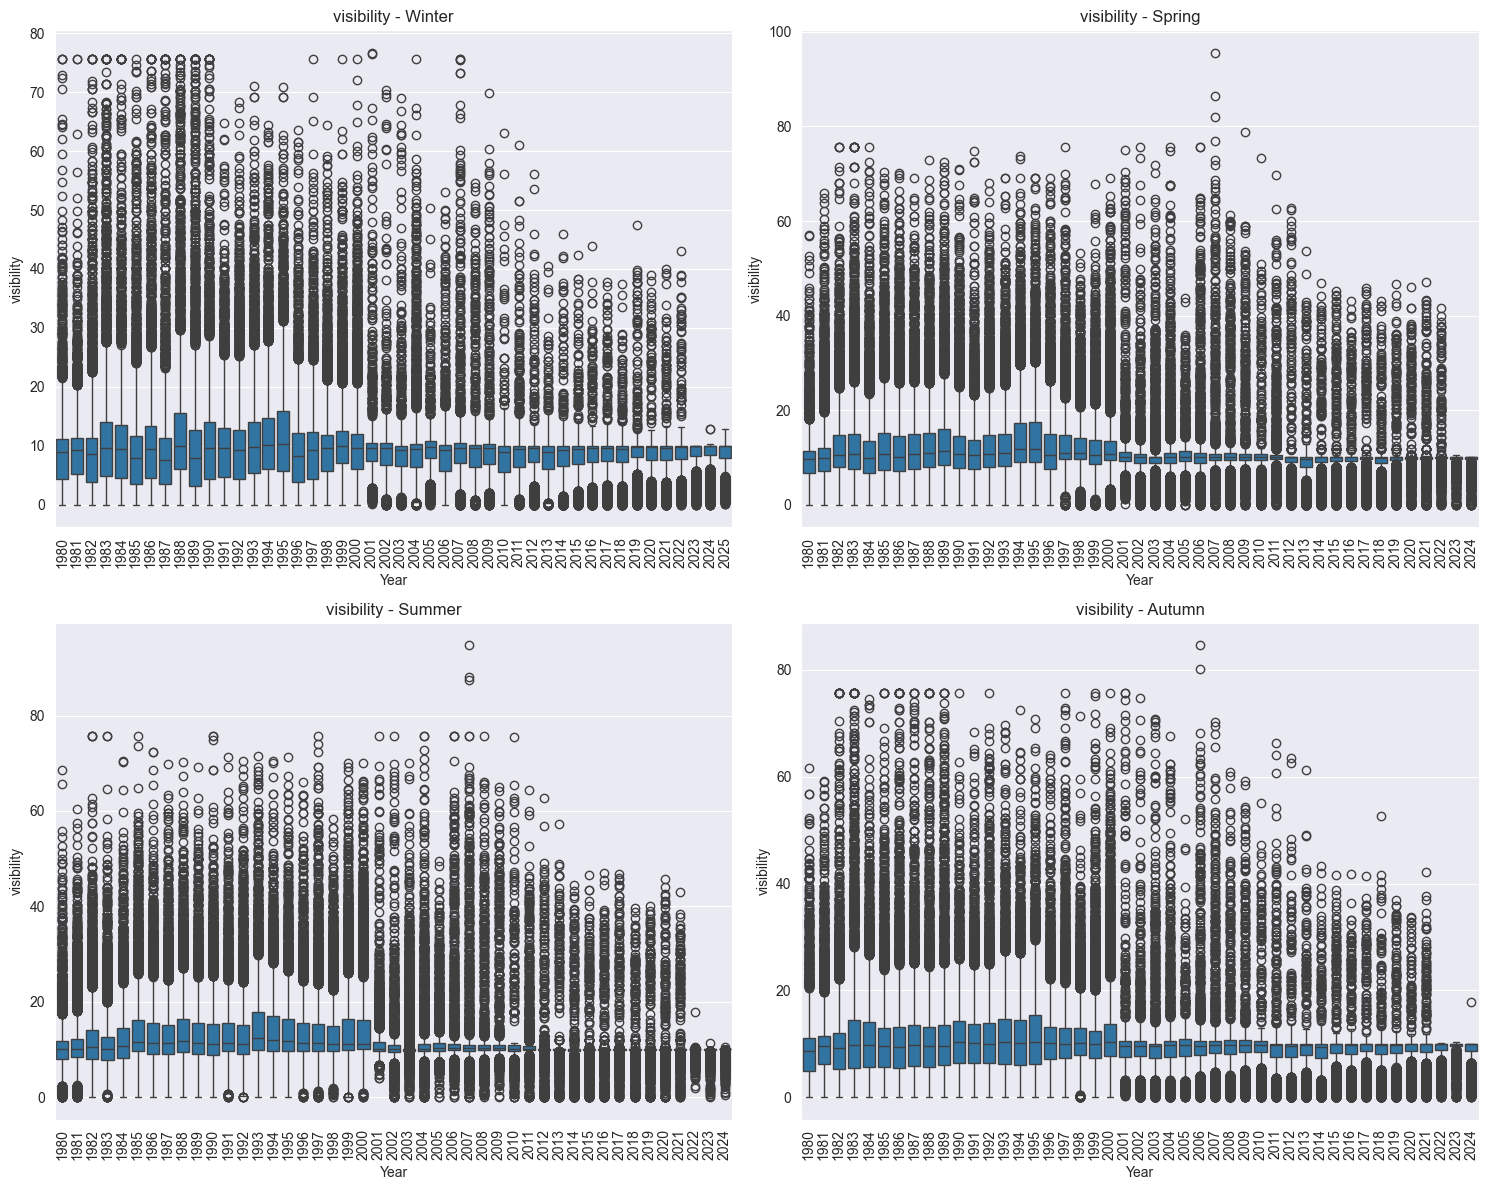

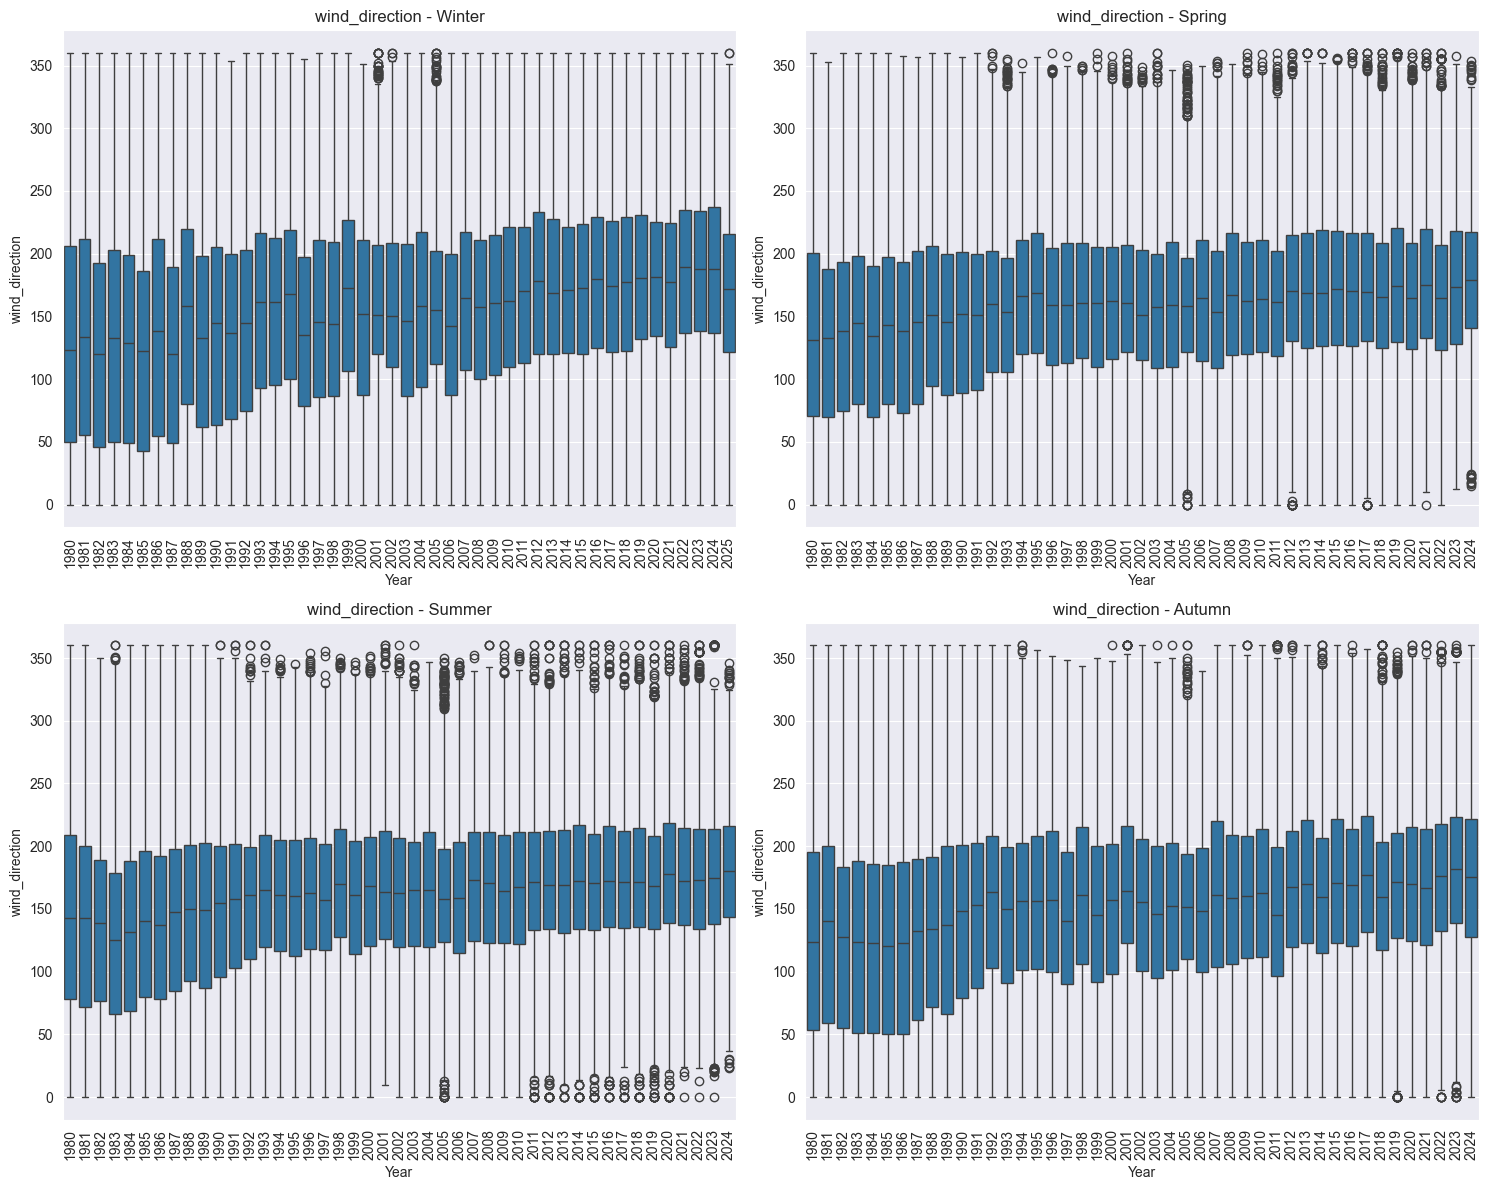

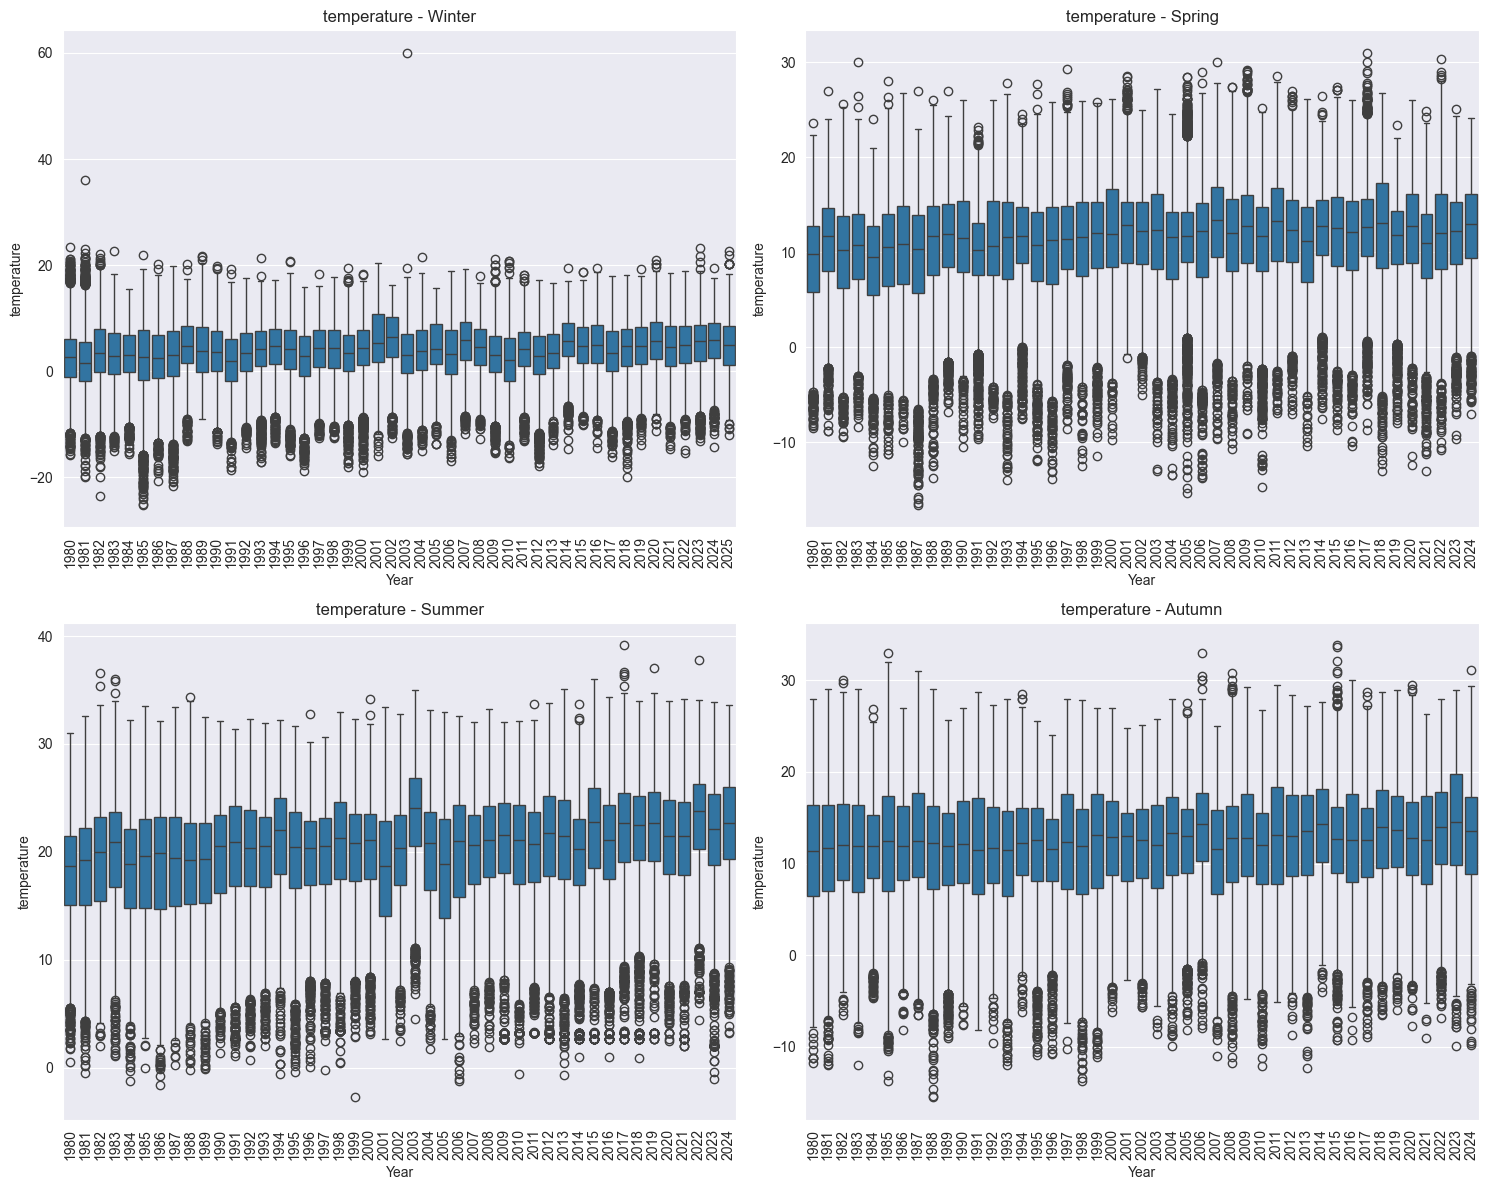

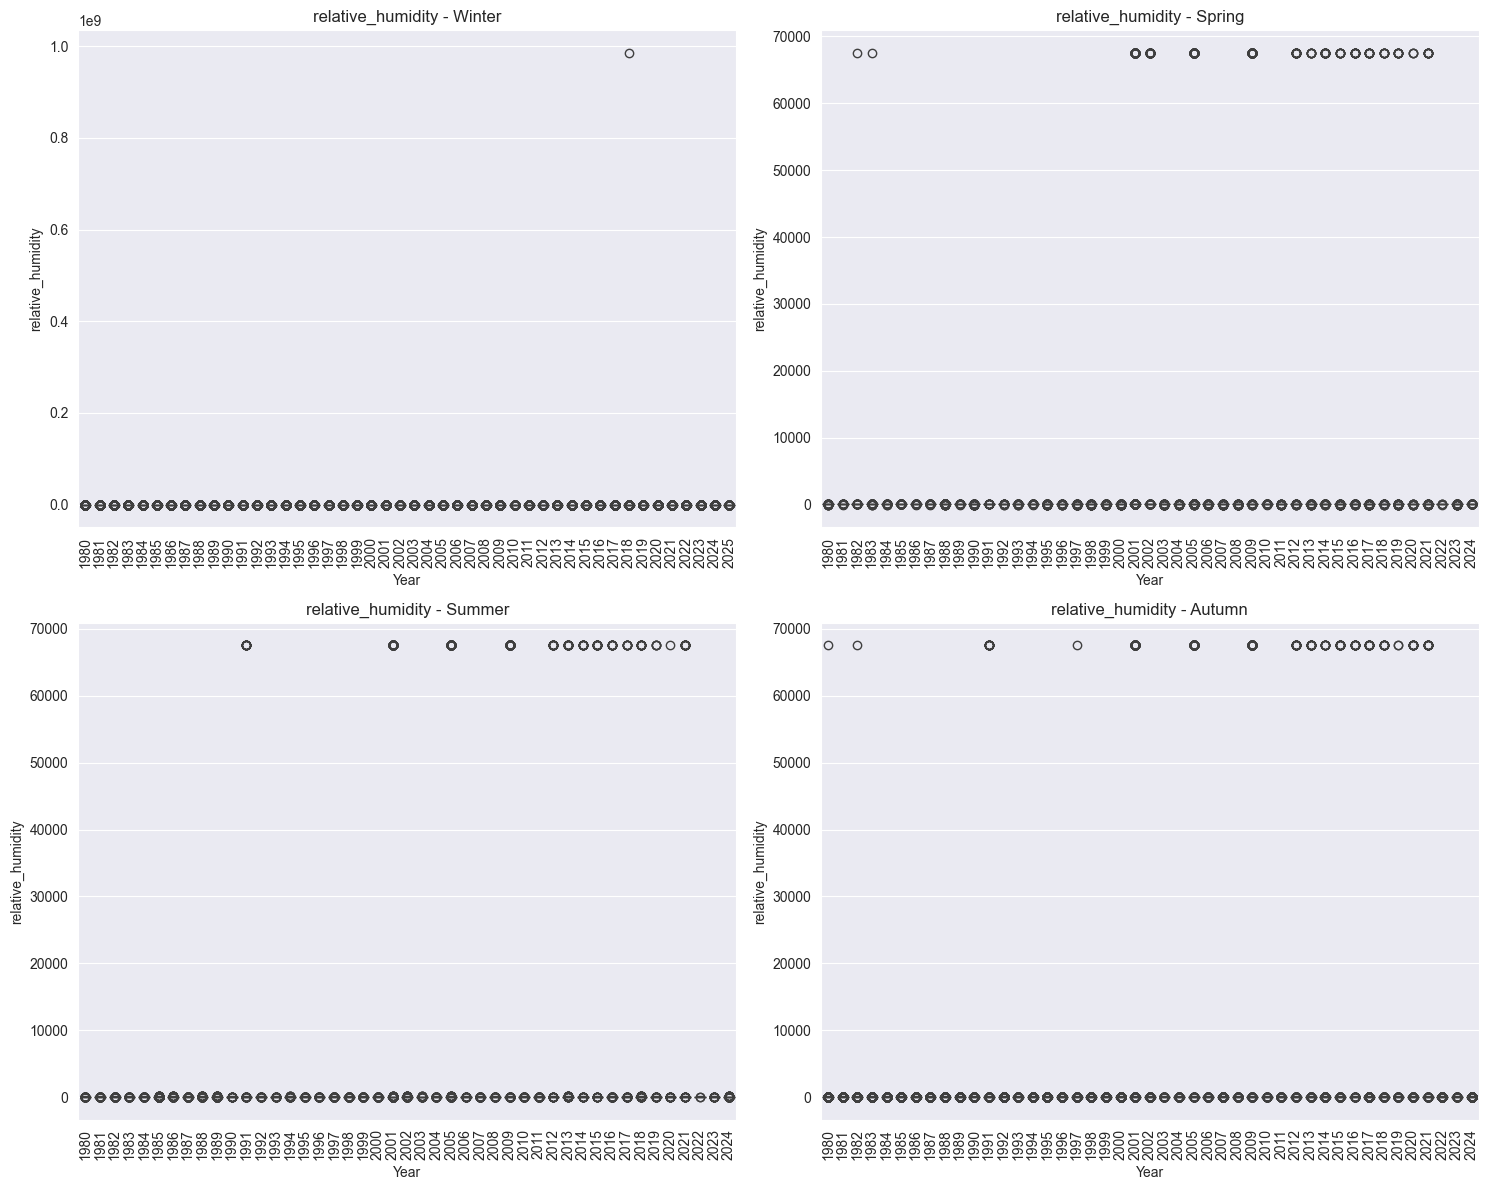

In [153]:
features = ["dew_point", "wind_direction", "temperature", "relative_humidity"]
seasons = main_df['season'].unique() 

for feature in features:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()  
    
    for i, season in enumerate(seasons):
        ax = axes[i] 
        
        season_data = main_df[main_df['season'] == season]
        
        sns.boxplot(data=season_data, x='year', y=feature, ax=ax)
        ax.tick_params(axis='x', rotation=90)
        ax.set_title(f"{feature} - {season}")
        ax.set_xlabel("Year")
        ax.set_ylabel(feature)
    
    plt.tight_layout() 
    plt.show() 

We notice so much outliers in all distributions. We decide to winsorizing to handle outliers. (Note that during our analysis we got "-36000" for relative_humidity and other bad values for station LIVP in 2018-02-28. This procedure ensure to leave out also this value, because relative_umidity is %)

In [3]:
def winsorize(s, lower_quantile=0.05, upper_quantile=0.95):
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

features = ["dew_point", "wind_direction", "relative_humidity"]

for feature in features:
    main_df[feature] = main_df.groupby('year')[feature].transform(lambda x: winsorize(x))
main_df["temperature"] = main_df.groupby(['year', 'elevation_group'])["temperature"].transform(lambda x: winsorize(x))

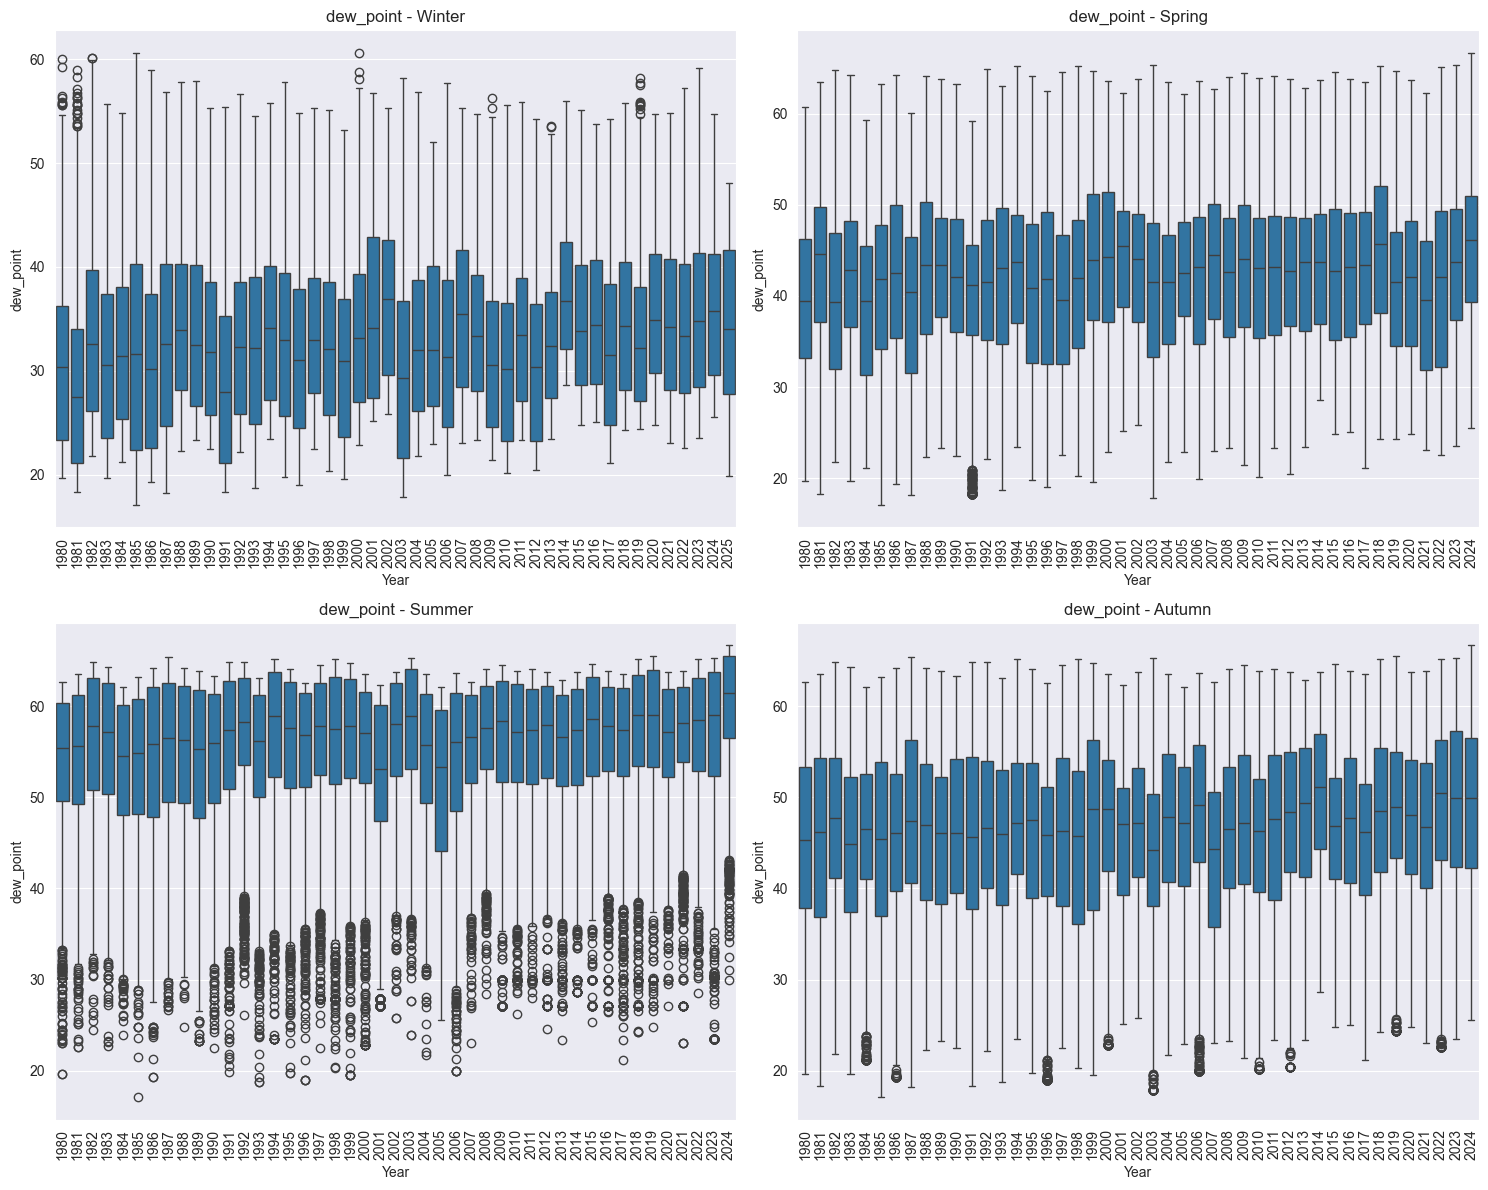

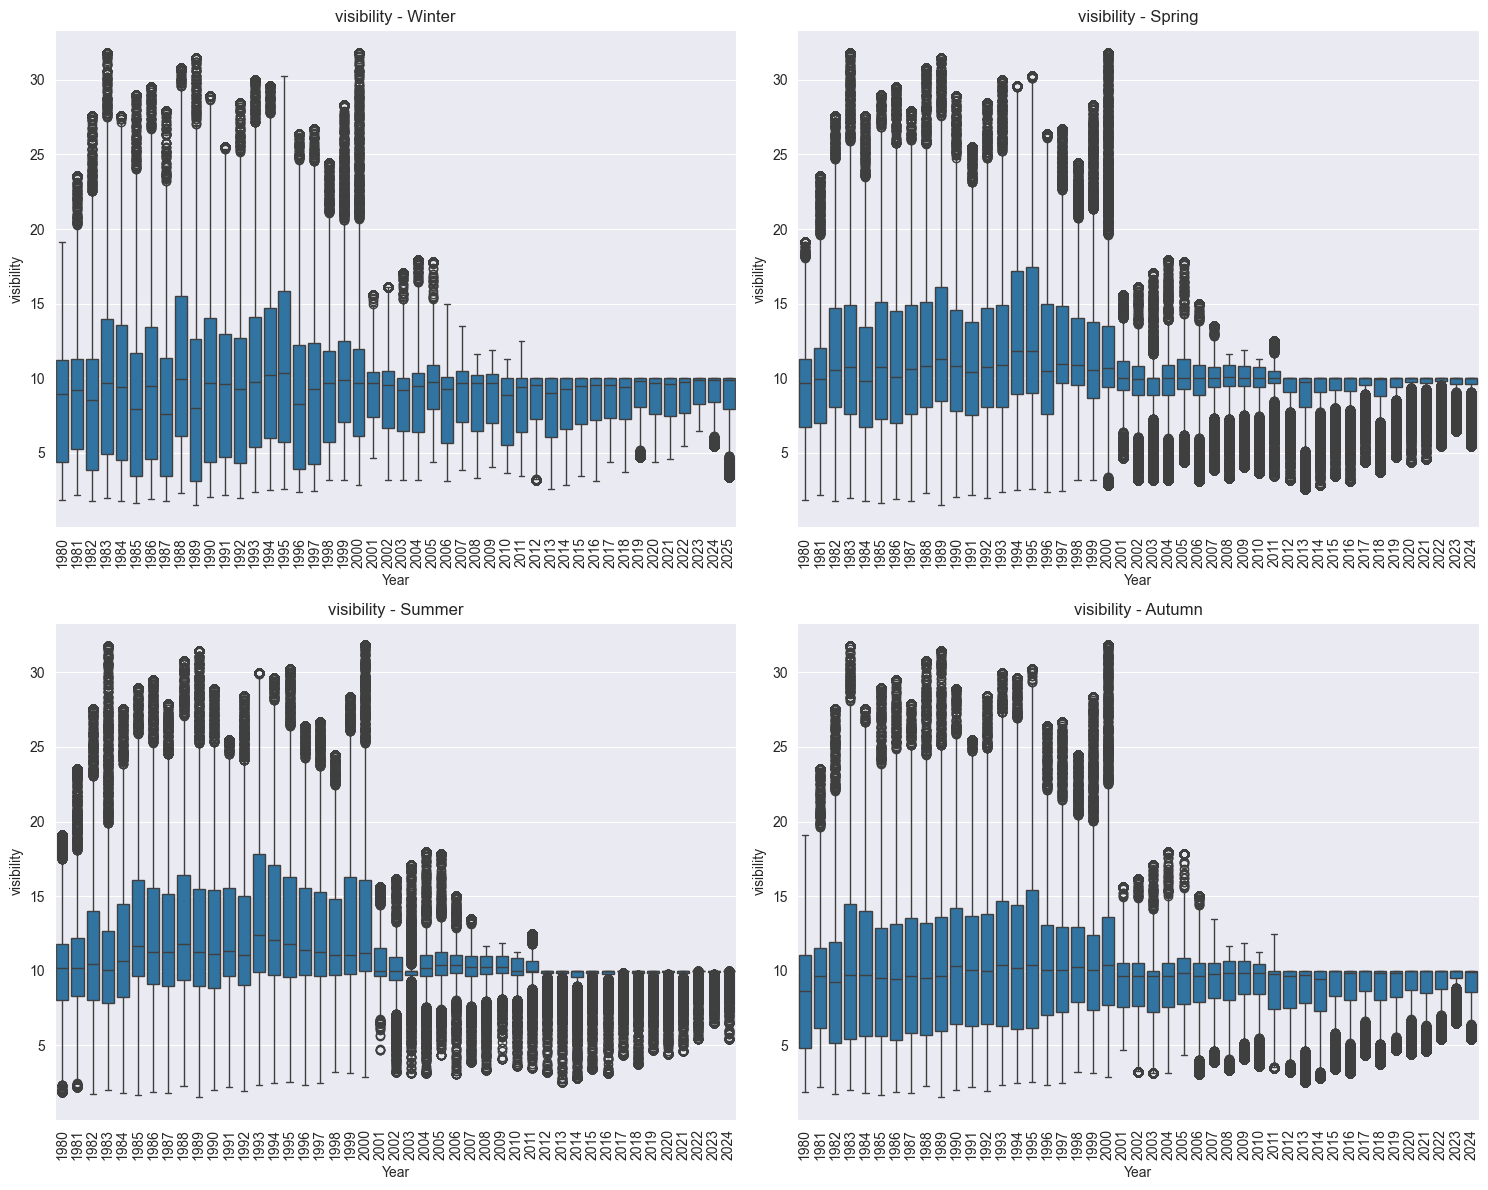

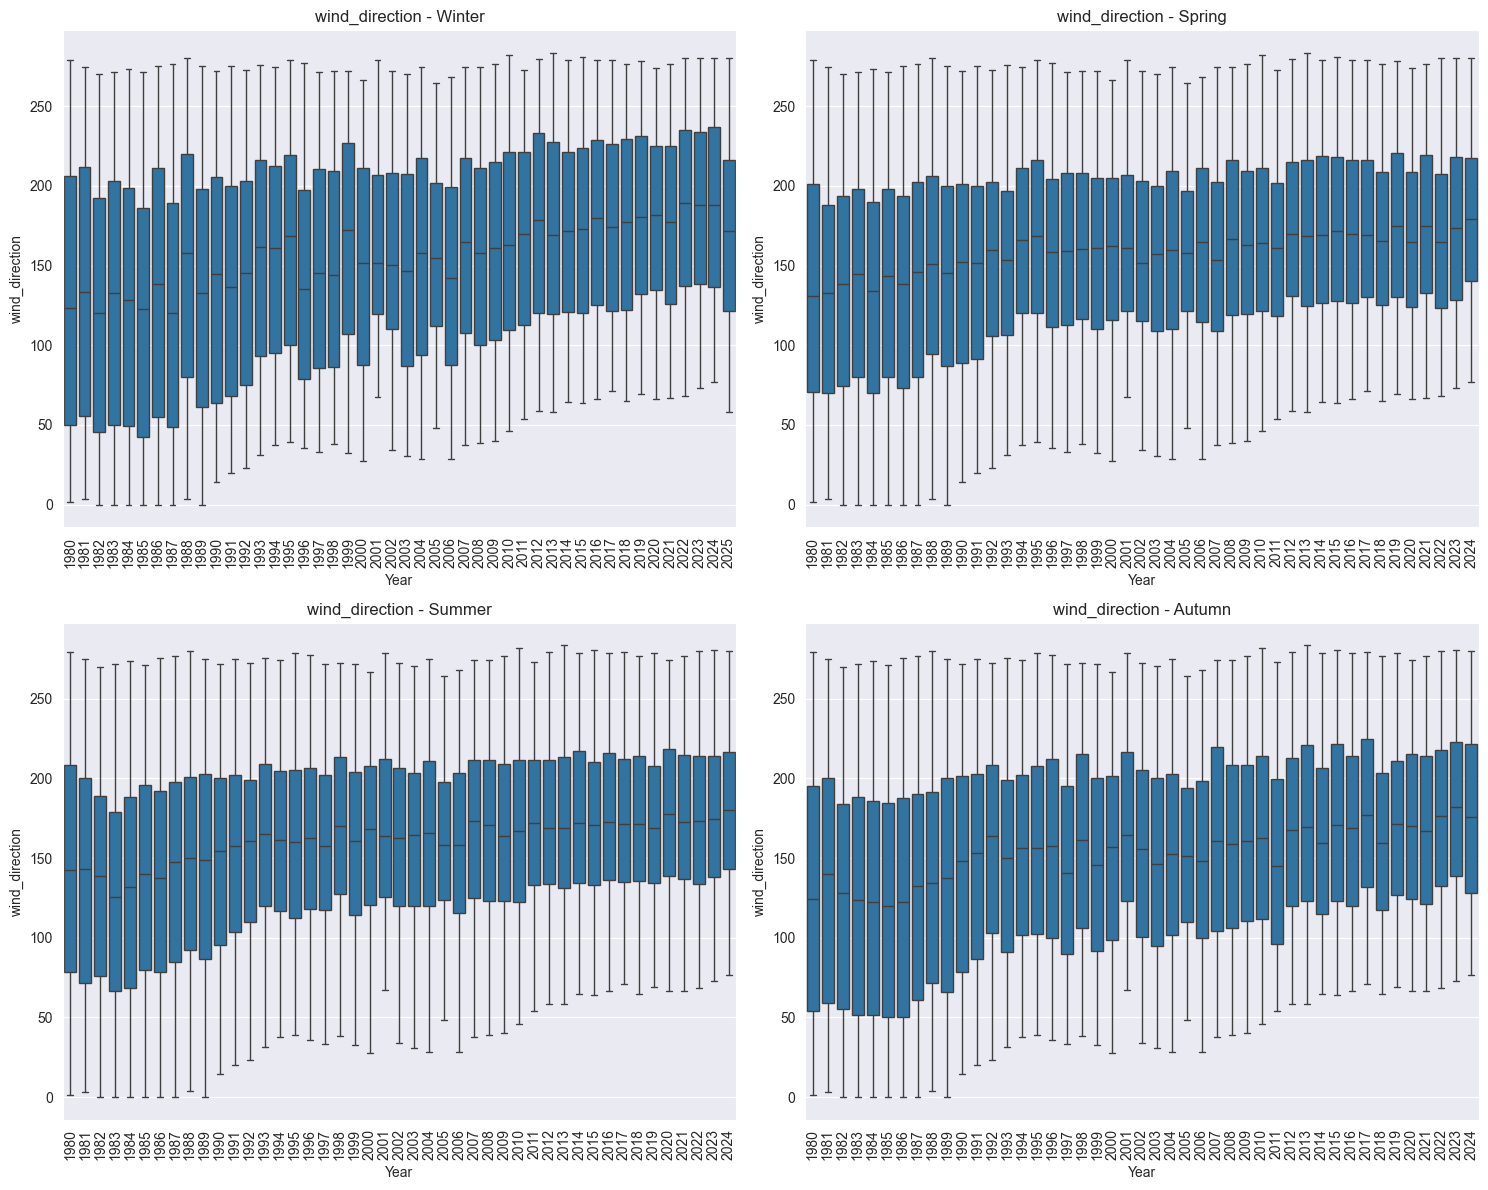

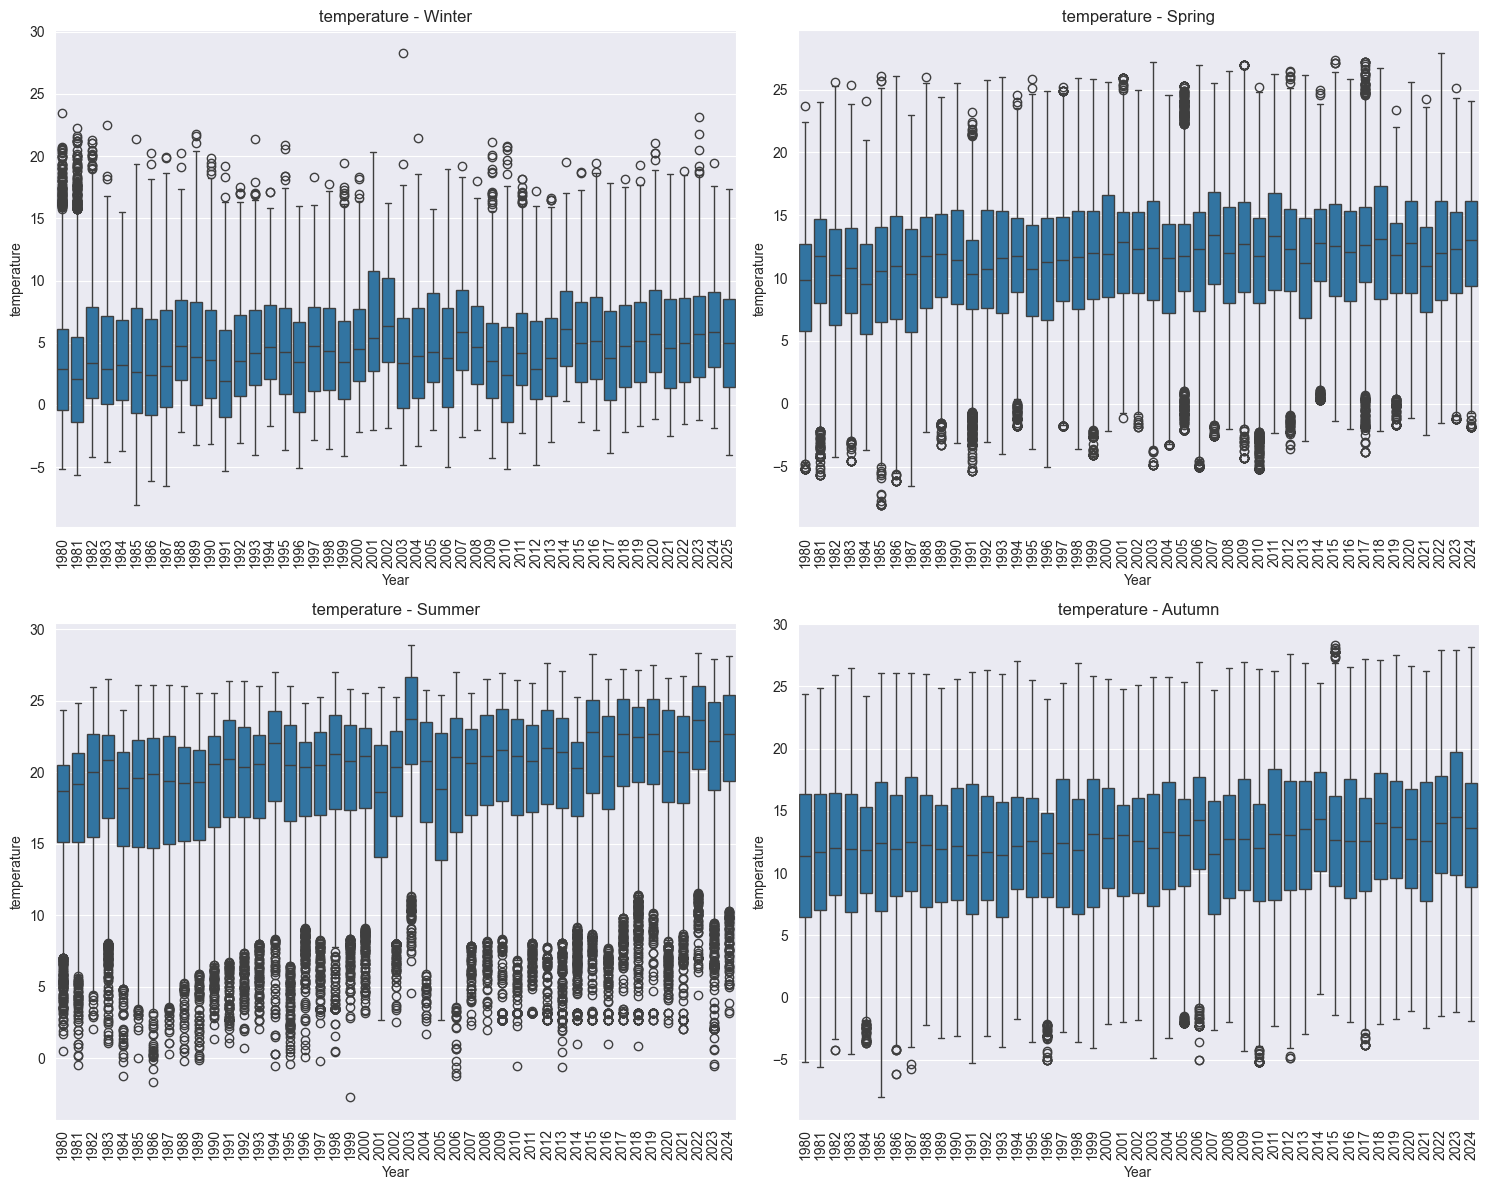

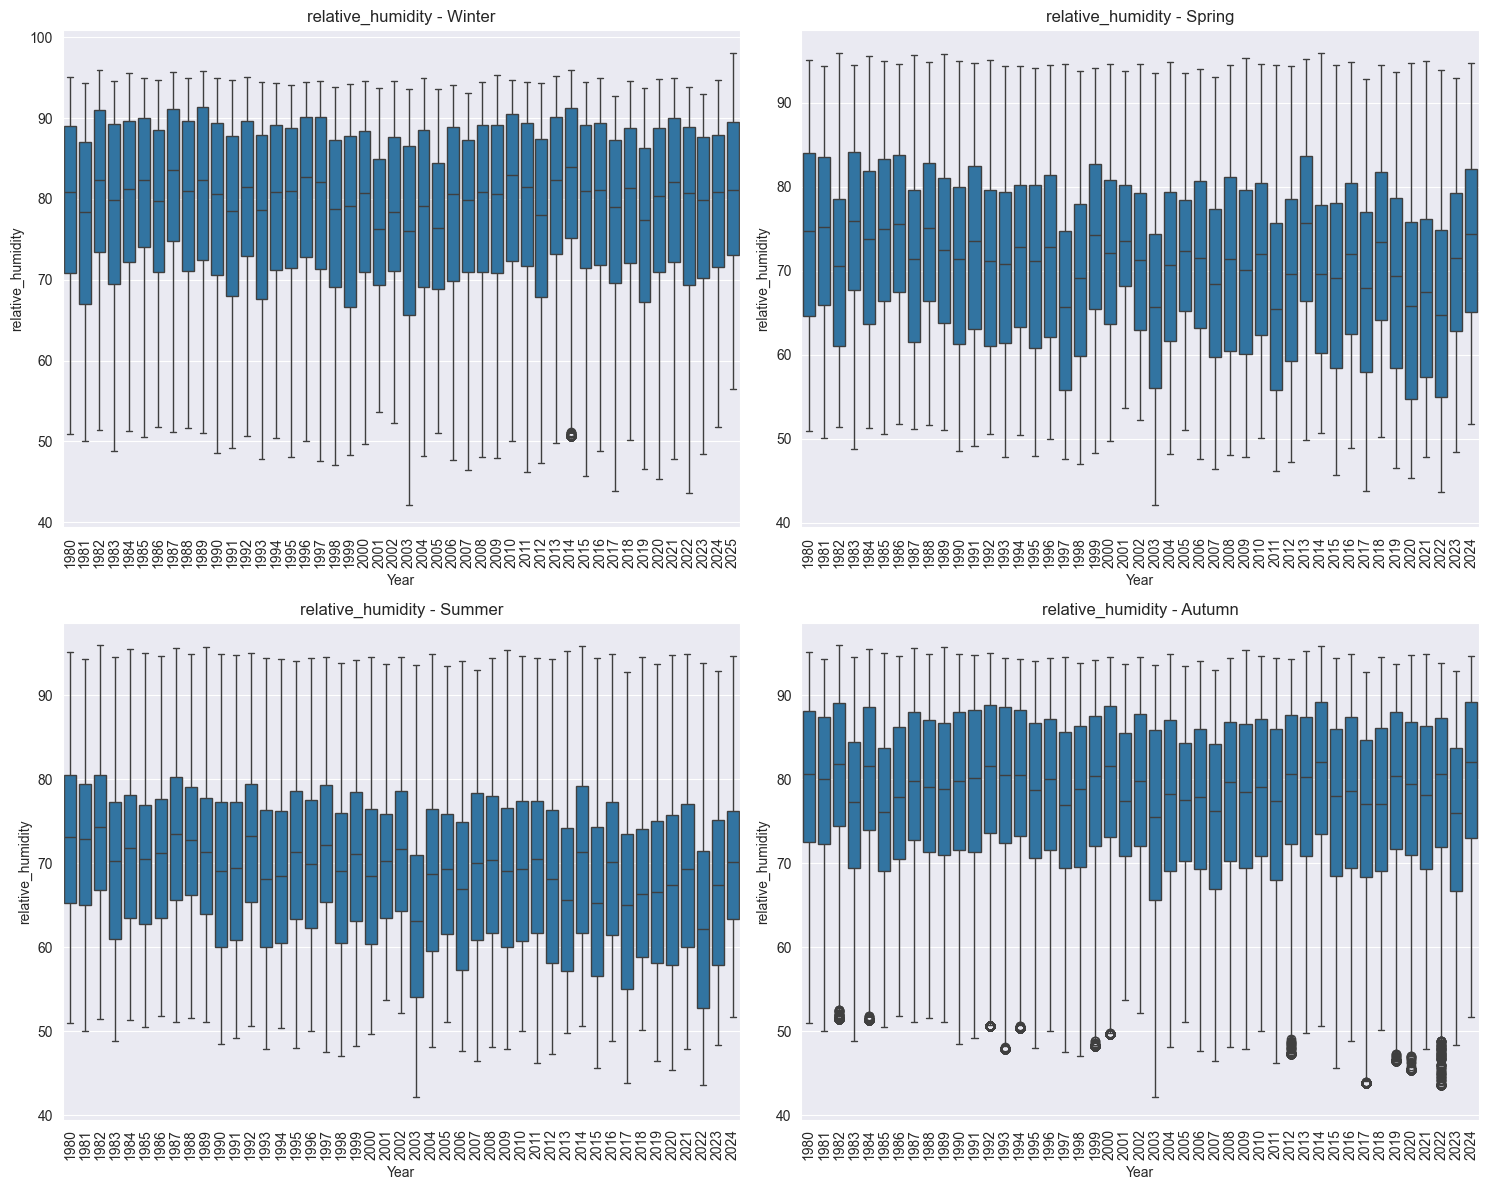

In [156]:
features = ["dew_point", "wind_direction", "temperature", "relative_humidity"]
seasons = main_df['season'].unique() 

for feature in features:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()  
    
    for i, season in enumerate(seasons):
        ax = axes[i] 
        
        season_data = main_df[main_df['season'] == season]
        
        sns.boxplot(data=season_data, x='year', y=feature, ax=ax)
        ax.tick_params(axis='x', rotation=90)
        ax.set_title(f"{feature} - {season}")
        ax.set_xlabel("Year")
        ax.set_ylabel(feature)
    
    plt.tight_layout() 
    plt.show() 

Now we can go on with analysis on these relevant features

In [4]:
features = ['lon', 'lat', 'elevation', 'temperature', 'dew_point', 'relative_humidity', 'wind_direction', 'station',
            'timestamp', 'year', 'month', 'day', 'region', 'elevation_group', 'season']
main_df = main_df[features]

Since our Valleys are in the South region, we want to analyze this region for first

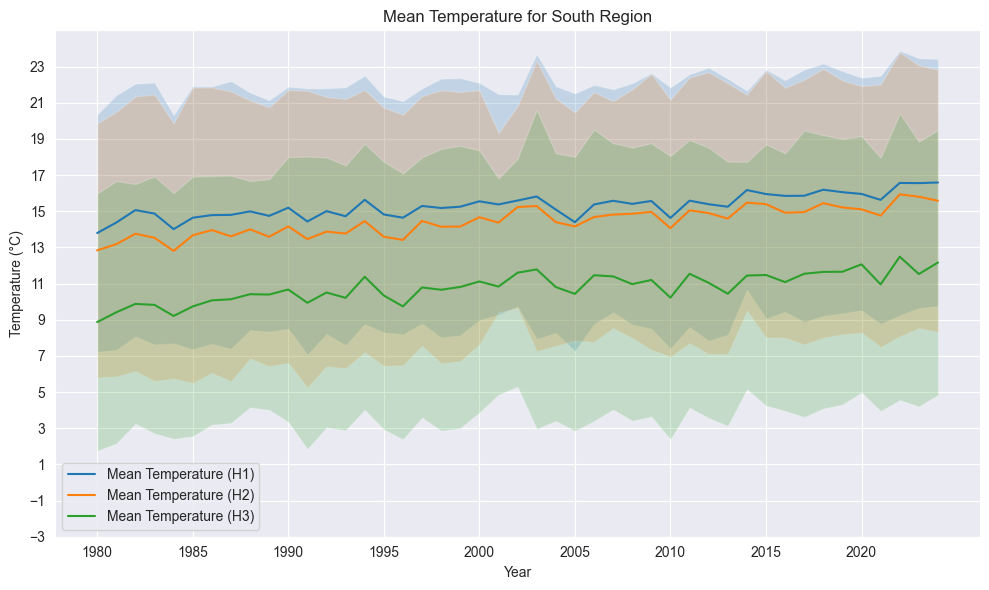

In [158]:
elevation_groups = main_df["elevation_group"].unique()
numeric_columns = main_df.select_dtypes(include=['number']).columns
alpha_dict = {"H1": 0.1, "H2": 0.1, "H3": 0.1}
plt.figure(figsize=(10, 6))

for elev_group in elevation_groups:
    if elev_group != "H0":
        t_mean_year_elev = main_df[(main_df["region"] == "S") & (main_df["elevation_group"] == elev_group) & (main_df["year"] < 2025)][numeric_columns].groupby("year").mean()
        t_std_year_elev = main_df[(main_df["region"] == "S") & (main_df["elevation_group"] == elev_group) & (main_df["year"] < 2025)][numeric_columns].groupby("year").std()
        
        plt.plot(t_mean_year_elev.index, t_mean_year_elev.temperature, label=f'Mean Temperature ({elev_group})')
        
        plt.fill_between(t_mean_year_elev.index, 
                         t_mean_year_elev.temperature - t_std_year_elev.temperature, 
                         t_mean_year_elev.temperature + t_std_year_elev.temperature, 
                         alpha=0.2)

plt.title("Mean Temperature for South Region")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.yticks(np.arange(-3, 25, 2)) 
plt.xticks(t_mean_year_elev.index[::5])
plt.ylim([-3, 25])
plt.legend()
plt.tight_layout()
plt.show()

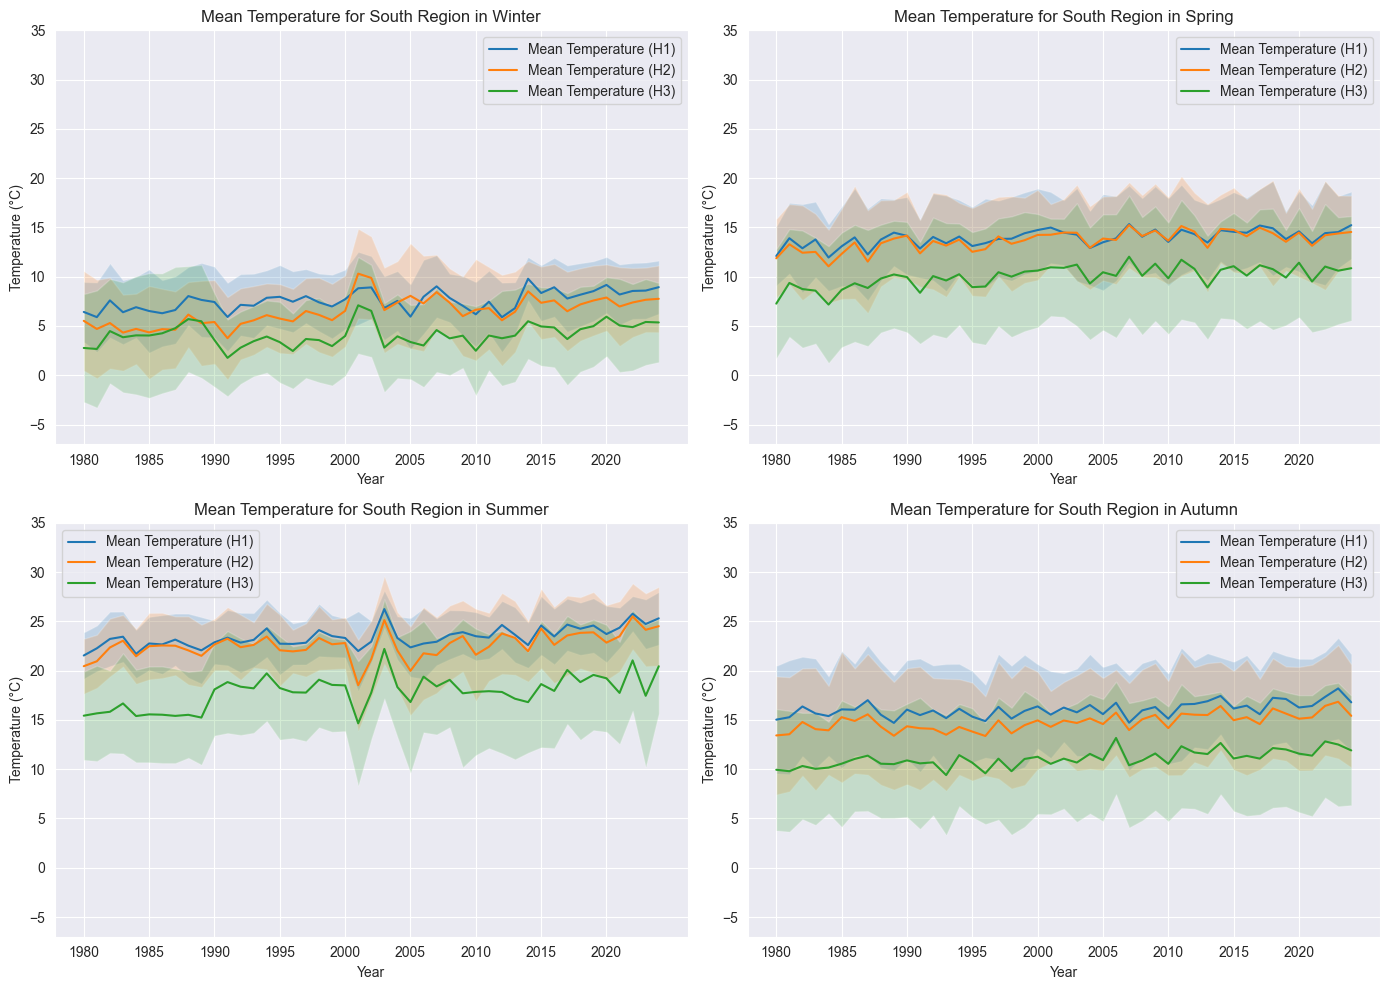

In [159]:
plt.figure(figsize=(14, 10))
numeric_columns = main_df.select_dtypes(include=['number']).columns

for elev in main_df["elevation_group"].unique():
    if elev != "H0":
        for idx, season in enumerate(seasons, start=1):
            season_data = main_df[(main_df["region"] == "S") & (main_df["season"] == season) & (main_df["year"] < 2025) & (main_df["elevation_group"] == elev)]
            
            t_mean_season = season_data[numeric_columns].groupby(['year']).mean().reset_index()
            t_std_season = season_data[numeric_columns].groupby(['year']).std().reset_index()
            
            plt.subplot(2, 2, idx)
                
            plt.plot(t_mean_season.year, t_mean_season.temperature, label=f'Mean Temperature ({elev})')
        
            plt.fill_between(t_mean_season.year, 
                             t_mean_season['temperature'] - t_std_season['temperature'], 
                             t_mean_season['temperature'] + t_std_season['temperature'], 
                             alpha=0.2)
            
            plt.title(f'Mean Temperature for South Region in {season}')
            plt.xlabel('Year')
            plt.xticks(t_mean_season.year[::5])
            plt.ylim([-7, 35])
            plt.ylabel('Temperature (°C)')
            plt.legend()

plt.tight_layout()
plt.show()

We notice that our elevation groups might be used by a model to better predict the temperature given an elevation value. Furthermore, a little difference in elevation bring anyway a significant differences in the mean temperature, both seasonal and year.

Now we are going to see max and min temperature reached respectively in Summer and Winter

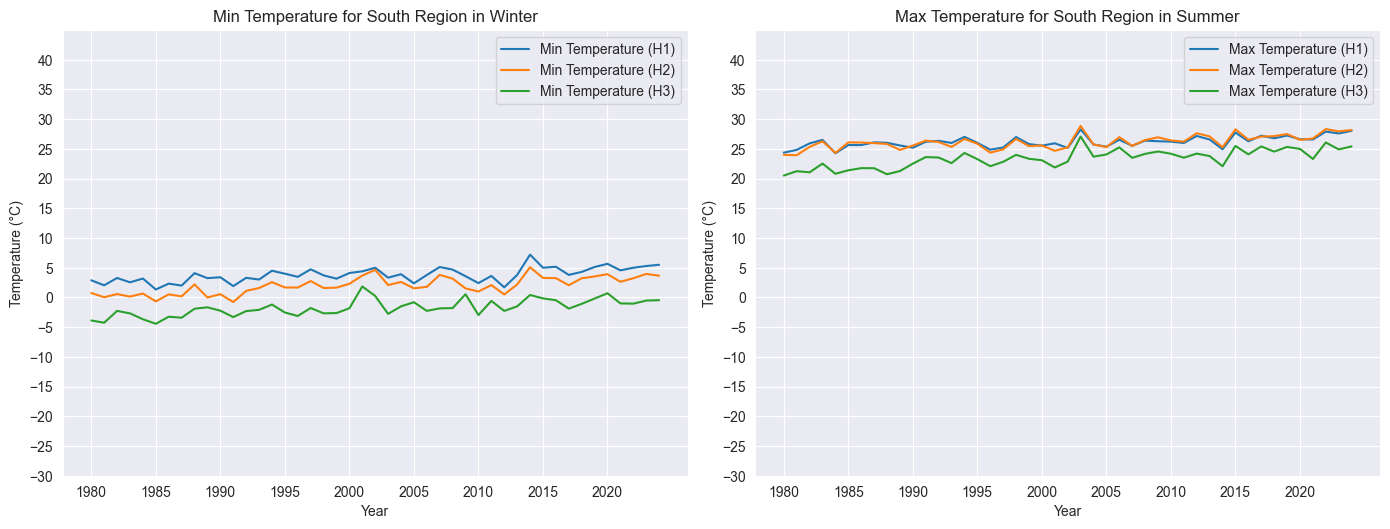

In [157]:
plt.figure(figsize=(14, 10))
numeric_columns = main_df.select_dtypes(include=['number']).columns

for elev in main_df["elevation_group"].unique():
    if elev != "H0":
        for idx, season in enumerate([seasons[0], seasons[2]], start=1):
            season_data = main_df[(main_df["region"] == "S") & (main_df["season"] == season) & (main_df["year"] < 2025) & (main_df["elevation_group"] == elev)]
            
            if season == "Winter":
                t_mean_season = season_data[numeric_columns].groupby(['year']).min().reset_index()
            else:
                t_mean_season = season_data[numeric_columns].groupby(['year']).max().reset_index()
                
            
            plt.subplot(2, 2, idx)
                
            plt.plot(t_mean_season.year, t_mean_season.temperature, label=f'{"Min" if season == "Winter" else "Max"} Temperature ({elev})')
            
            plt.title(f'{"Min" if season == "Winter" else "Max"} Temperature for South Region in {season}')
            plt.xlabel('Year')
            plt.xticks(t_mean_season.year[::5])
            plt.ylim([-30, 45])
            plt.ylabel('Temperature (°C)')
            plt.yticks(np.arange(-30, 45, 5)) 
            plt.legend()


plt.tight_layout()
plt.show()

We note not so much difference during Summer, so high temperatures are reached no matter the elevations. Instead in Winter we notice that stations with higher elevation reach lower temperatures (as expected). 
<br>
Now we are going to make the same plots also for the other regions.

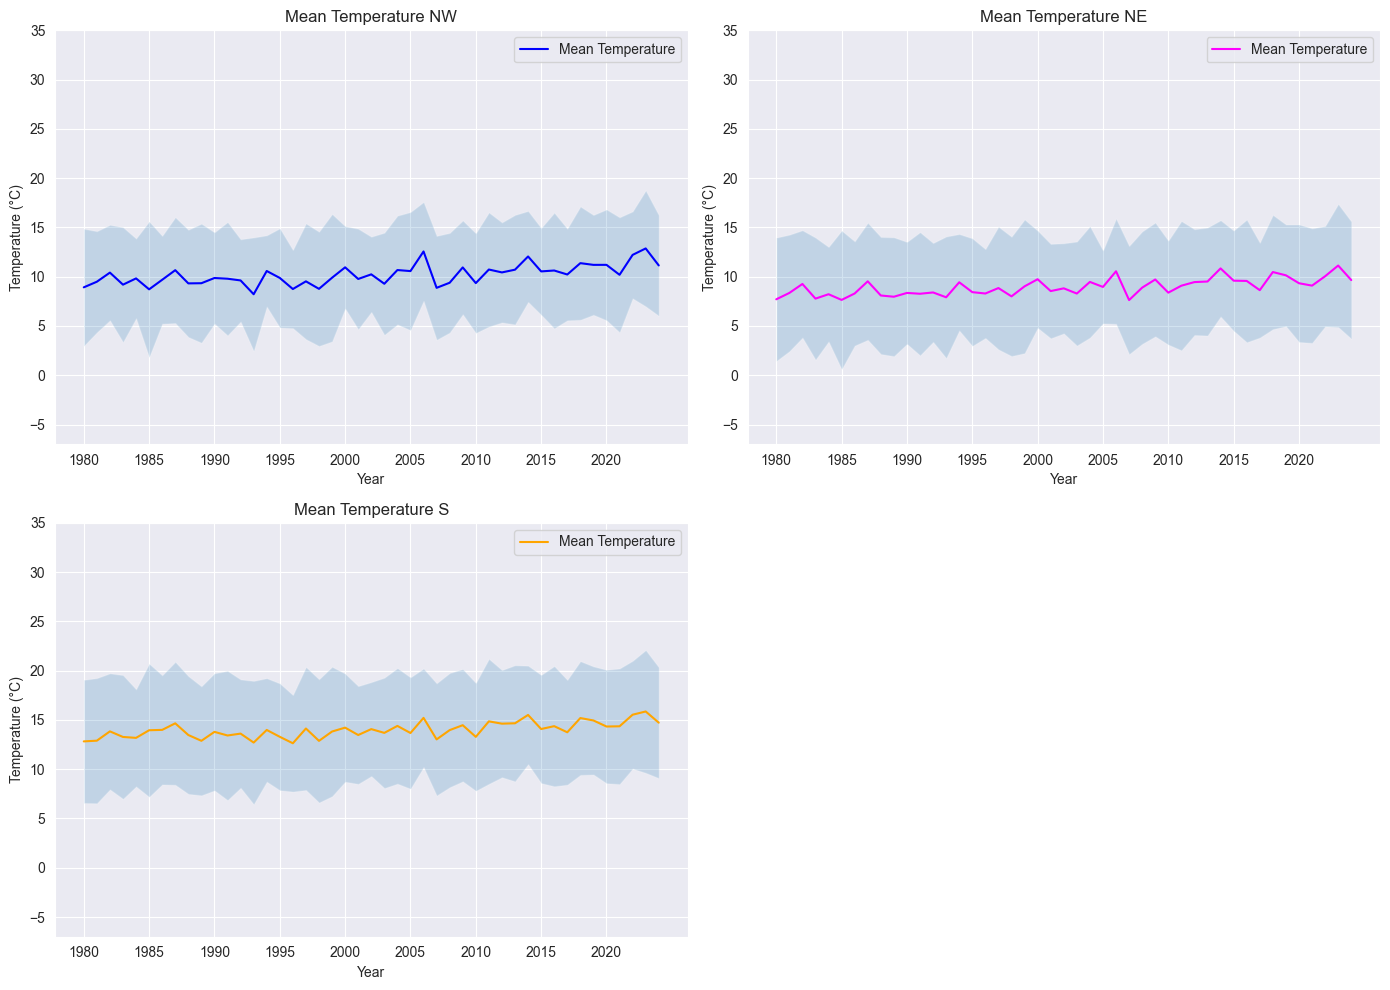

In [160]:
plt.figure(figsize=(14, 10))
numeric_columns = main_df.select_dtypes(include=['number']).columns

color = ["blue", "magenta", "orange"]

for idx, region in enumerate(["NW", "NE", "S"]):
    season_data = main_df[(main_df["region"] == region) & (main_df["season"] == season) & (main_df["year"] < 2025)]
    
    feature_mean_season = season_data[numeric_columns].groupby(['year']).mean().reset_index()
    feature_std_season = season_data[numeric_columns].groupby(['year']).std().reset_index()
    
    plt.subplot(2, 2, idx+1)
        
    plt.plot(feature_mean_season.year, feature_mean_season["temperature"], label=f'Mean Temperature', color=color[idx])

    plt.fill_between(feature_mean_season.year, 
                     feature_mean_season["temperature"] - feature_std_season["temperature"], 
                     feature_mean_season["temperature"] + feature_std_season["temperature"], 
                     alpha=0.2)
    
    plt.title(f'Mean Temperature {region}')
    plt.xlabel('Year')
    plt.xticks(feature_mean_season.year[::5])
    plt.ylim([-7, 35])
    plt.ylabel(f'Temperature (°C)')
    plt.legend()

plt.tight_layout()
plt.show()

Here we notice a positive trend in each plot. Moreover there is an evident difference for the three regions: South region reachs higher temperatures than the North regions (as expected)

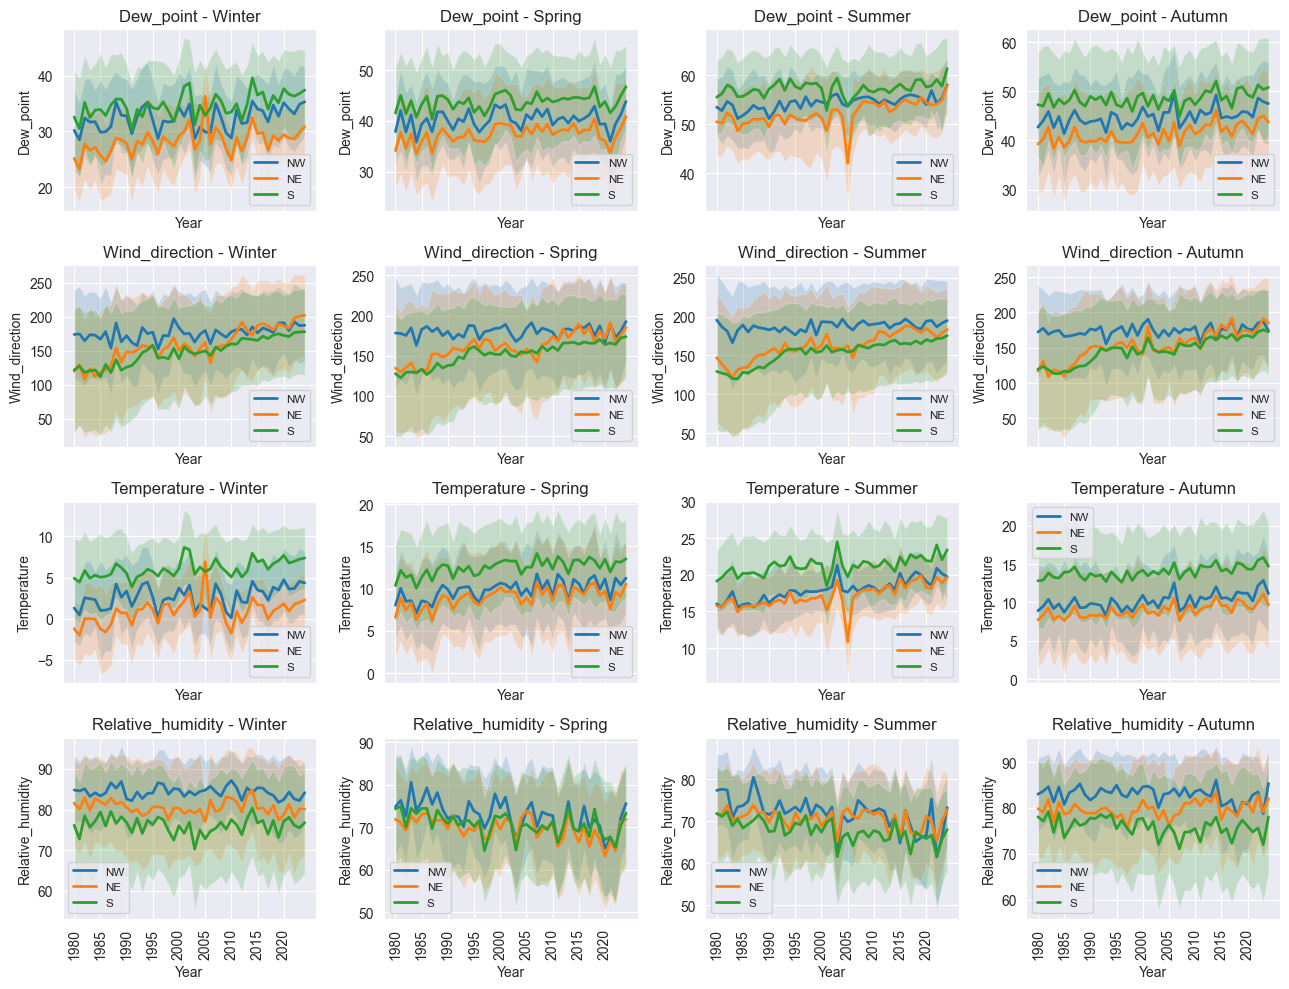

In [23]:
features = ["dew_point", "wind_direction", "temperature", "relative_humidity"]
regions = ["NW", "NE", "S"]

fig, axes = plt.subplots(nrows=len(features), ncols=len(seasons), figsize=(13, 10), sharex=True)
factor = 1

for i, feature in enumerate(features):
    for j, season in enumerate(seasons):
        ax = axes[i, j]
        
        for region in regions:
            season_data = main_df[
                (main_df["region"] == region) & 
                (main_df["season"] == season) & 
                (main_df["year"] < 2025)
            ]
            
            if  feature == "wind_speed":
                factor = 3.6
            else:
                factor = 1
                
            season_data.loc[season_data['season'] == season, feature] *= factor
            feature_mean_season = season_data.groupby('year')[feature].mean().reset_index()
            feature_std_season = season_data.groupby('year')[feature].std().reset_index()
            
            ax.plot(feature_mean_season.year, feature_mean_season[feature],
                    label=f'{region}', lw=2)
            ax.fill_between(feature_mean_season.year,
                            feature_mean_season[feature] - feature_std_season[feature],
                            feature_mean_season[feature] + feature_std_season[feature],
                            alpha=0.2)
        
        ax.set_title(f'{feature.capitalize()} - {season}')
        ax.set_xlabel('Year')
        ax.set_xticks(feature_mean_season.year[::5]) 
        ax.tick_params(axis='x', rotation=90)
        ax.set_ylabel(f'{feature.capitalize()}')
        ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()

# Analyze sesonality

In [6]:
from scipy import stats

In [4]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
temp_means = []
temp_stds = []
months_combined = []
for year in range(1980, 2025): 
    
    for month in months:
        monthly_data = main_df[
            (main_df["year"] == year) &
            (main_df["month"] == month) &
            (main_df["region"] == "S")
        ]
        
        temp_mean = monthly_data["temperature"].mean()
        temp_std = monthly_data["temperature"].std()

        months_combined.append(f'{year}-{month}')
        temp_means.append(temp_mean)
        temp_stds.append(temp_std)

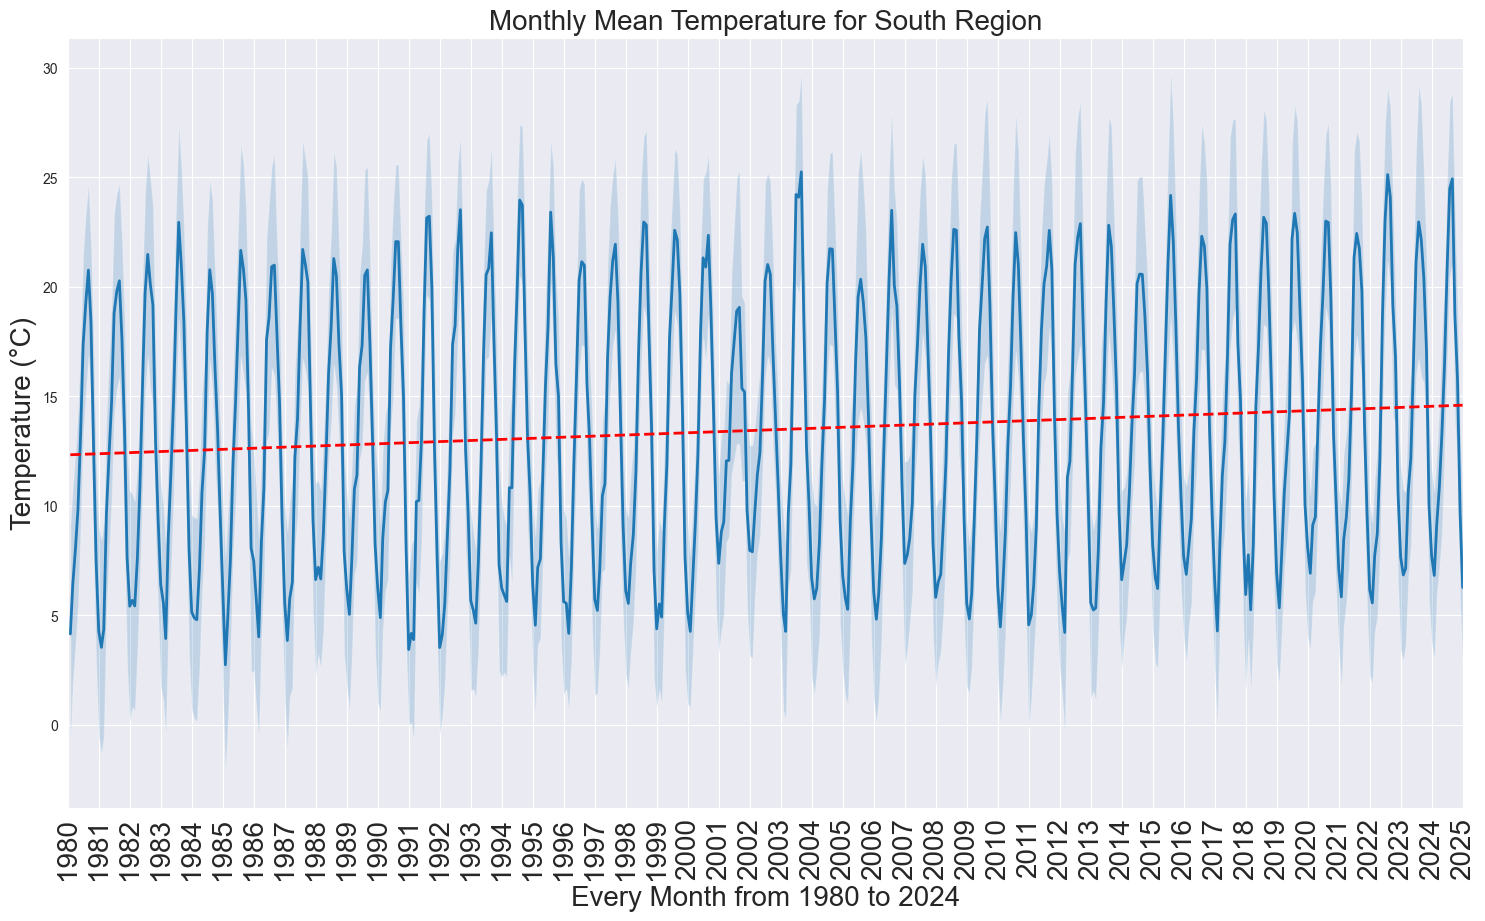

In [8]:
temp_month = pd.date_range(start='1980-01-01', end="2024-12-31", freq='ME')

import matplotlib.dates as mdates
plt.figure(figsize=(18, 10)) 
plt.plot(temp_month, temp_means, label=f'Year {year} Mean Temperature', lw=2)
plt.fill_between(temp_month, 
                [m - s for m, s in zip(temp_means, temp_stds)], 
                [m + s for m, s in zip(temp_means, temp_stds)], 
                alpha=0.2)

plt.xticks(temp_month[::12], rotation=90)
x_vals = np.arange(len(months_combined))

slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, temp_means)
fit_values = slope * x_vals + intercept
plt.plot(temp_month, fit_values, label=f'Linear Fit (slope={slope:.2f})', color='red', linestyle='--', lw=2)

plt.title('Monthly Mean Temperature for South Region', fontsize=20)
plt.xlabel('Every Month from 1980 to 2024', fontsize=20)
plt.ylabel('Temperature (°C)', fontsize=20)
plt.xticks(temp_month[::12], rotation=90, fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # One tick per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(pd.to_datetime('1980-01-01'), pd.to_datetime('2025-01-01'))
plt.show()

We can see a little positive trend and a clear seasonality: every 6 months. We decide to plot the autocorrelation to better see this behaviour.

(20.0, 40.0)

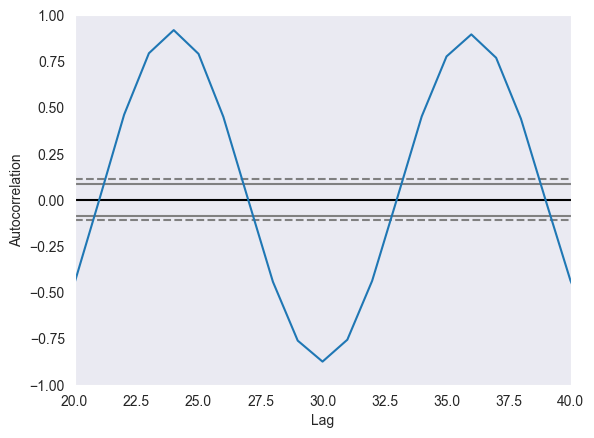

In [48]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(temp_means)
plt.xlim([20, 40])

In [0]:
main_df1 = main_df[['lon', 'lat', 'elevation', 'temperature', 'dew_point', 'relative_humidity', 'wind_direction', 'station', 'elevation_group', 'season', "region", "day", "month", "year"]]
main_df1.to_csv("final_dataset-27-02-25.csv", index=False)

# Model Development

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [53]:
elevation_cat_for_region = {'S': {'H1': (0.9144, 12.8016),
                            'H2': (12.8016, 72.23760000000003),
                            'H3': (72.23760000000003, 662.3304)},
                            'NW': {'H1': (46.93919999999999, 69.1896),
                            'H2': (69.1896, 106.68),
                            'H3': (106.68, 171.29760000000005)},
                            'NE': {'H1': (73.45679999999999, 117.95759999999996),
                            'H2': (117.95759999999996, 177.08880000000002),
                            'H3': (177.08880000000002, 611.4288)}
                            }
season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring',  5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

season_mapping_forecast = {
    12: 3, 1: 3, 2: 3,
    3: 1, 4: 1,  5: 1,
    6: 2, 7: 2, 8: 2,
    9: 0, 10: 0, 11: 0
}

In [30]:
df = pd.read_csv("final_dataset-01-03-25.csv")
df = df[df["region"] == "S"]
df['dew_point'] = (df['dew_point'].astype(float) - 32) * 5/9 # from °F to °C

filtered_df = df[["lon", "lat", "elevation", "temperature", "dew_point", "relative_humidity", "wind_direction", "timestamp", "station"]]
filtered_df_aggregate = filtered_df.groupby(["timestamp", "station"]).mean()
filtered_df_aggregate["region"] = "S"
filtered_df_aggregate["elevation_group"] = filtered_df_aggregate.apply(lambda row: assign_elevation_group(row['elevation'], row["region"]), axis=1)
filtered_df_aggregate = filtered_df_aggregate.reset_index()
filtered_df_aggregate["timestamp"] = pd.to_datetime(filtered_df_aggregate["timestamp"])
filtered_df_aggregate['month'] = filtered_df_aggregate["timestamp"].dt.month
filtered_df_aggregate['season'] = filtered_df_aggregate["month"].map(season_mapping)
filtered_df_aggregate.to_csv("dataset-for-ML.csv", index=False)

NameError: name 'assign_elevation_group' is not defined

Since we found some seasonality in the data, we decide to train and also predict mean values of temperature for each month. Further more we focus on the South region, so our model is more custom for the task

In [186]:
def get_season_from_name(month_name):
    if month_name in ["December", "January", "February"]:
        return "Winter"
    elif month_name in ["March", "April", "May"]:
        return "Spring"
    elif month_name in ["June", "July", "August"]:
        return "Summer"
    else:
        return "Autumn"

Now we train a model to predict each target feature carring about different stations. We decide to focus on mean month values. So for each target feature we have 300 predictions: from 2025 to 2050. 

In [0]:
df = pd.read_csv("dataset-for-ML.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["day"] = df["timestamp"].dt.day
df["year"] = df["timestamp"].dt.year

features = ["station", "lon", "lat", "elevation", "region", "elevation_group", "day", "month", "year", "season"]

for target in ["temperature", "dew_point", "relative_humidity", "wind_direction"]:
    

    df['station'] = df['station'].astype('category').cat.codes
    df['region'] = df['region'].astype('category').cat.codes
    df['season'] = df['season'].astype('category').cat.codes
    df['elevation_group'] = df['elevation_group'].astype('category').cat.codes
    
    df["day"] = df["day"].astype(int)
    df['month'] = df['month'].astype(int)
    df["year"] = df["year"].astype(int)
    
    
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=177)
    
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=177, max_depth=16)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    
    forecast_dates = pd.date_range(start="2024-06-26", end="2050-12-31", freq="ME")
    all_last_six = None
    features_target = features + [target]
    for station in df["station"].unique():
        last_six = df[(df["year"] < 2025) & (df["station"] == station)].groupby(["year", "month", "day"]).mean().tail(6).reset_index()
        last_six = last_six[features_target].reset_index()
        last_six.drop("index", axis=1, inplace=True)
        if all_last_six is not None:
            all_last_six =pd.concat([all_last_six, last_six], ignore_index=True)
        else:
            all_last_six = last_six.copy()
            
    all_last_six = all_last_six[features_target]
    forecast_df = all_last_six.copy()
    
    for forecast_date in forecast_dates:
        
        for station in df["station"].unique():
            station_df = df[df["station"] == station]
            new_row = {
                "station": station,
                "lat": station_df["lat"].iloc[0],
                "lon": station_df["lon"].iloc[0],
                'elevation': station_df["elevation"].iloc[0],
                "elevation_group": station_df["elevation_group"].iloc[0],
                'region': 0,   
                "year": forecast_date.year,
                "month": forecast_date.month,
                "day": forecast_date.day,
                'season': season_mapping_forecast[forecast_date.month]
            }
            
            # Current station for current date
            new_row_df = pd.DataFrame(new_row, index=[forecast_date])
            X_new_value_for_station = new_row_df[features]
        
            temp_pred_for_station = model.predict(X_new_value_for_station)[0]
            
            new_row[target] = temp_pred_for_station
            new_row_df = pd.DataFrame(new_row, index=[forecast_date])
            forecast_df = pd.concat([forecast_df, new_row_df], ignore_index=True)
        
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=30, kde=True, color="blue")
    plt.axvline(0, color='red', linestyle='dashed')  
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residuals Distribution")
    plt.show()
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    
    plt.figure(figsize=(12,6))
    plt.plot(df["timestamp"].unique(), df.groupby(["year", "month", "day"]).mean()[target], label=f"Historical {target.capitalize()}", alpha=0.6)
    plt.plot(pd.date_range(start="2025-01-01", end="2050-12-31", freq="ME"), forecast_df[forecast_df['year']>2024].groupby(["year", "month", "day"]).mean()[target], label=f"Forecasted {target.capitalize()}", color="red")
    plt.xticks(pd.date_range(start="1980-01-01", end="2050-12-31", freq="ME")[::60], rotation=90)
    plt.xlabel("Date")
    plt.ylabel(f"{target.capitalize()} °")
    plt.title(f"{target.capitalize()} Forecast from 2025 to 2050")
    plt.legend()
    plt.show()

    forecast_df[forecast_df['year']>2024].to_csv(f"{target}-predicted.csv", index=False)

Now we train a model to predict each target feature carring about Val di Susa latitude and longitude. We decide to focus on mean month values. So for each target feature we have 300 predictions: from 2025 to 2050.

Test MSE: 3.864916247159768


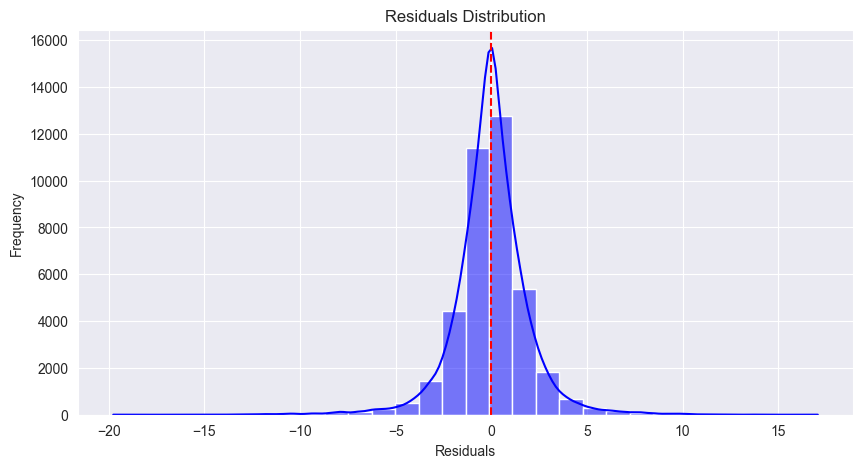

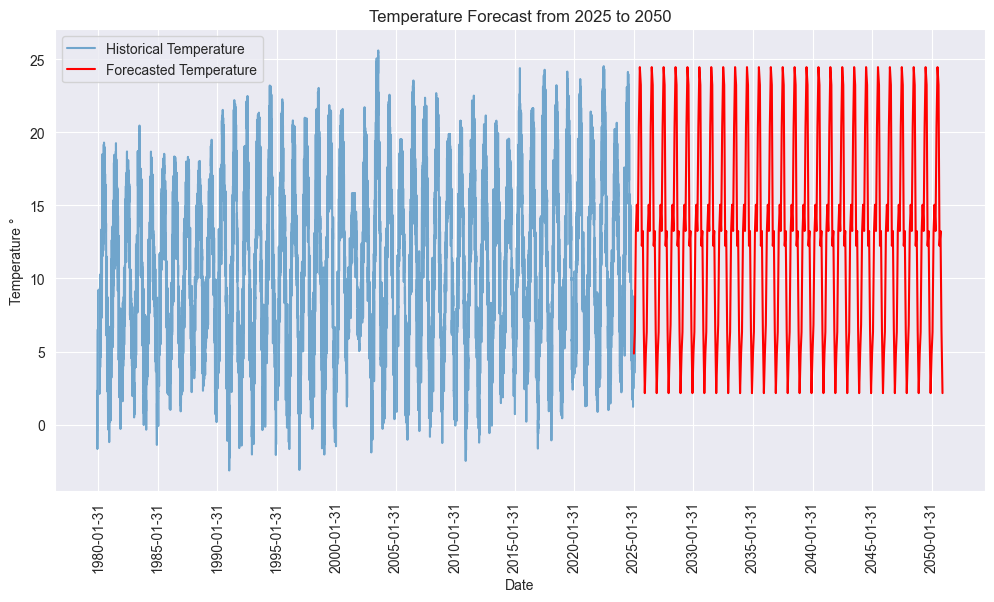

Test MSE: 5.1108187949737305


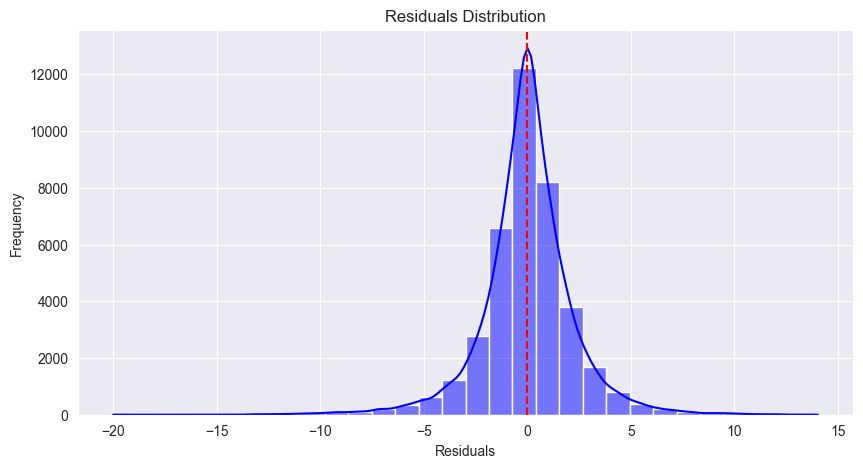

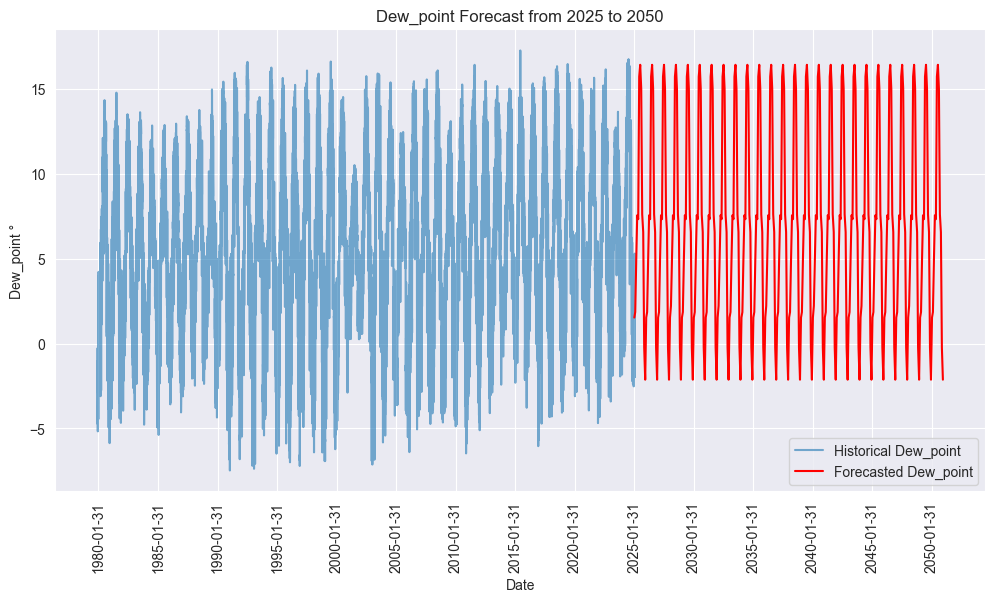

Test MSE: 84.33604335275064


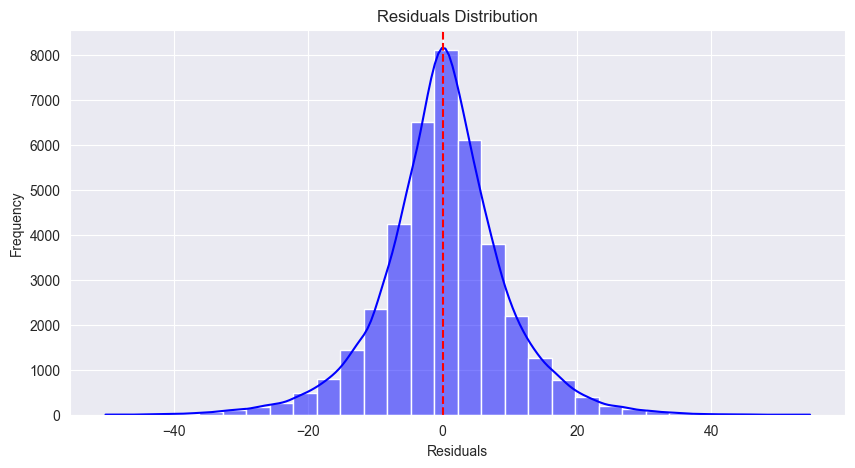

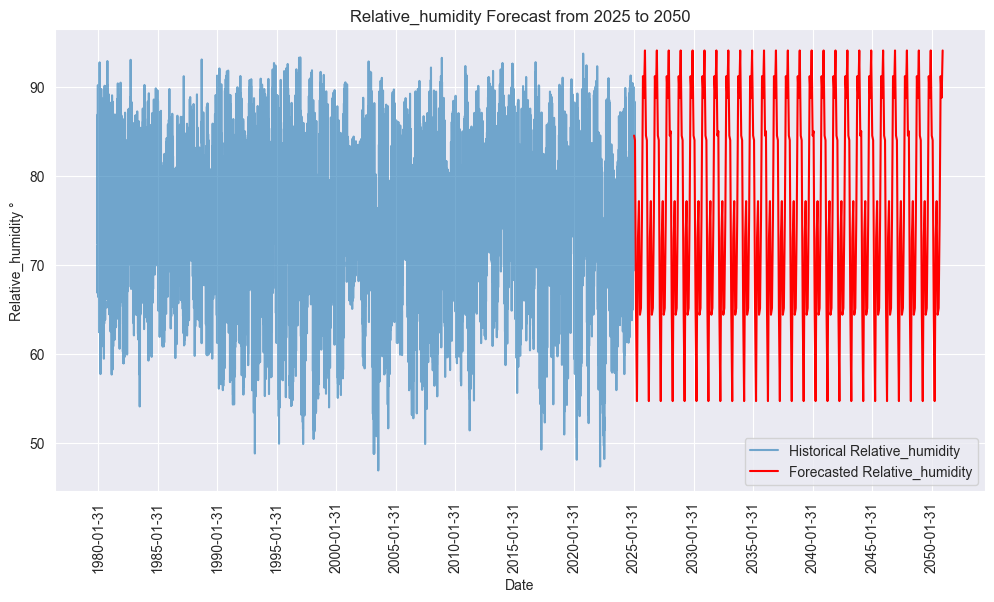

Test MSE: 3240.2881217279237


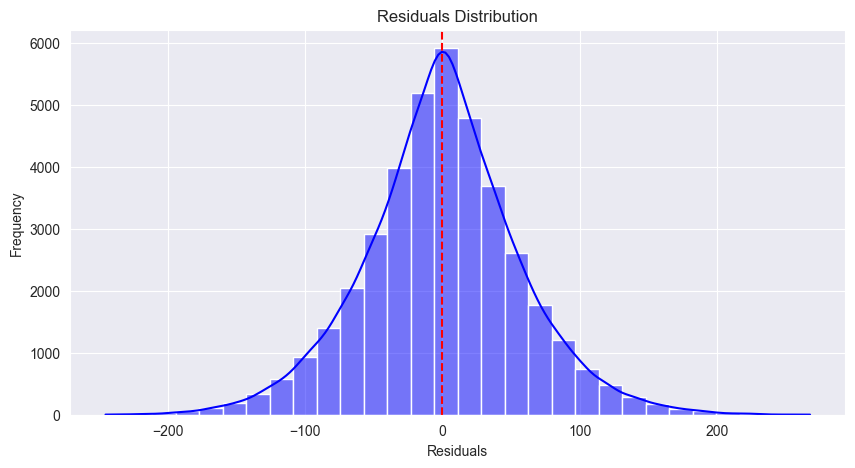

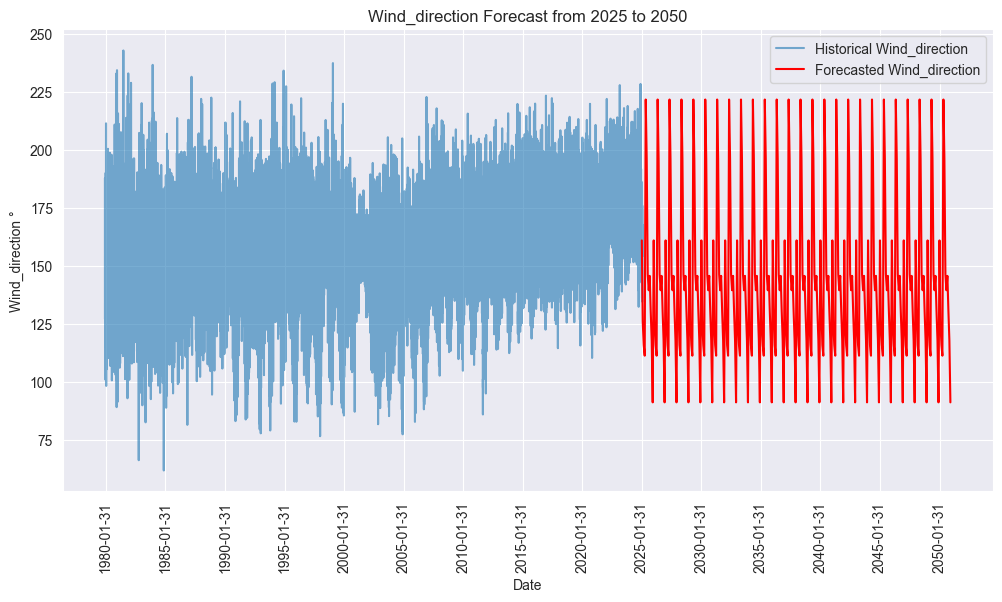

In [96]:
df = pd.read_csv("dataset-for-ML.csv")
df = df[df["elevation_group"] == "H3"]
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["day"] = df["timestamp"].dt.day
df["year"] = df["timestamp"].dt.year

features = ["station", "lon", "lat", "elevation", "region", "elevation_group", "day", "month", "year", "season"]

for target in ["temperature", "dew_point", "relative_humidity", "wind_direction"]:
    
    df['station'] = df['station'].astype('category').cat.codes
    df['region'] = df['region'].astype('category').cat.codes
    df['season'] = df['season'].astype('category').cat.codes
    df['elevation_group'] = df['elevation_group'].astype('category').cat.codes
    
    df["day"] = df["day"].astype(int)
    df['month'] = df['month'].astype(int)
    df["year"] = df["year"].astype(int)
    
    
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=177)
    
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=177, max_depth=16)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    
    forecast_dates = pd.date_range(start="2024-06-26", end="2050-12-31", freq="ME")
    all_last_six = None
    features_target = features + [target]
    for station in df["station"].unique():
        last_six = df[(df["year"] < 2025) & (df["station"] == station)].groupby(["year", "month", "day"]).mean().tail(6).reset_index()
        last_six = last_six[features_target].reset_index()
        last_six.drop("index", axis=1, inplace=True)
        if all_last_six is not None:
            all_last_six =pd.concat([all_last_six, last_six], ignore_index=True)
        else:
            all_last_six = last_six.copy()
            
    all_last_six = all_last_six[features_target]
    forecast_df = all_last_six.copy()
    
    for forecast_date in forecast_dates:
        
        new_row = {
            "station": 36,
            "lat": 45.13872816833292,
            "lon": 7.165070254268173,
            'elevation': 400,
            "elevation_group": 3,
            'region': 0,   
            "year": forecast_date.year,
            "month": forecast_date.month,
            "day": forecast_date.day,
            'season': season_mapping_forecast[forecast_date.month]
        }
        
        # Current station for current date
        new_row_df = pd.DataFrame(new_row, index=[forecast_date])
        X_new_value_for_station = new_row_df[features]
    
        temp_pred_for_station = model.predict(X_new_value_for_station)[0]
        
        new_row[target] = temp_pred_for_station
        new_row_df = pd.DataFrame(new_row, index=[forecast_date])
        forecast_df = pd.concat([forecast_df, new_row_df], ignore_index=True)
        
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=30, kde=True, color="blue")
    plt.axvline(0, color='red', linestyle='dashed')  
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residuals Distribution")
    plt.show()
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    
    plt.figure(figsize=(12,6))
    plt.plot(df["timestamp"].unique(), df.groupby(["year", "month", "day"]).mean()[target], label=f"Historical {target.capitalize()}", alpha=0.6)
    plt.plot(pd.date_range(start="2025-01-01", end="2050-12-31", freq="ME"), forecast_df[forecast_df['year']>2024].groupby(["year", "month", "day"]).mean()[target], label=f"Forecasted {target.capitalize()}", color="red")
    plt.xticks(pd.date_range(start="1980-01-01", end="2050-12-31", freq="ME")[::60], rotation=90)
    plt.xlabel("Date")
    plt.ylabel(f"{target.capitalize()} °")
    plt.title(f"{target.capitalize()} Forecast from 2025 to 2050")
    plt.legend()
    plt.show()

    forecast_df[forecast_df['year']>2024].to_csv(f"susa-{target}-predicted.csv", index=False)

Now we train a model to predict each target feature carring about Val de Maurienne latitude and longitude. We decide to focus on mean month values. So for each target feature we have 300 predictions: from 2025 to 2050.

Test MSE: 3.864916247159768


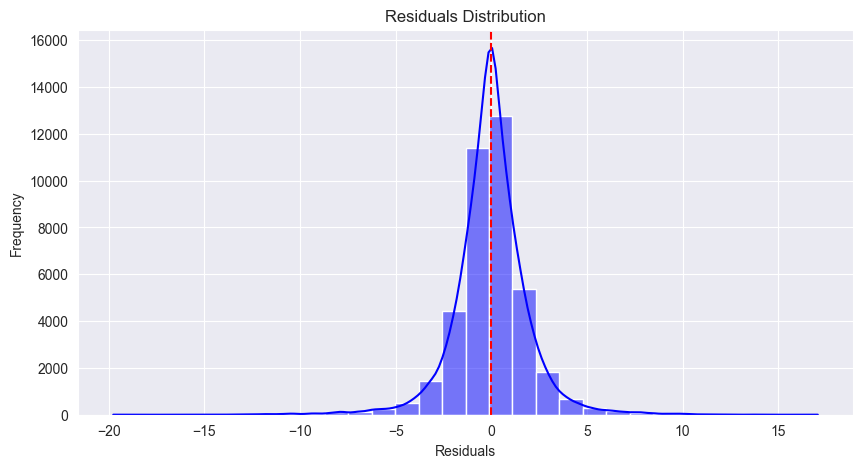

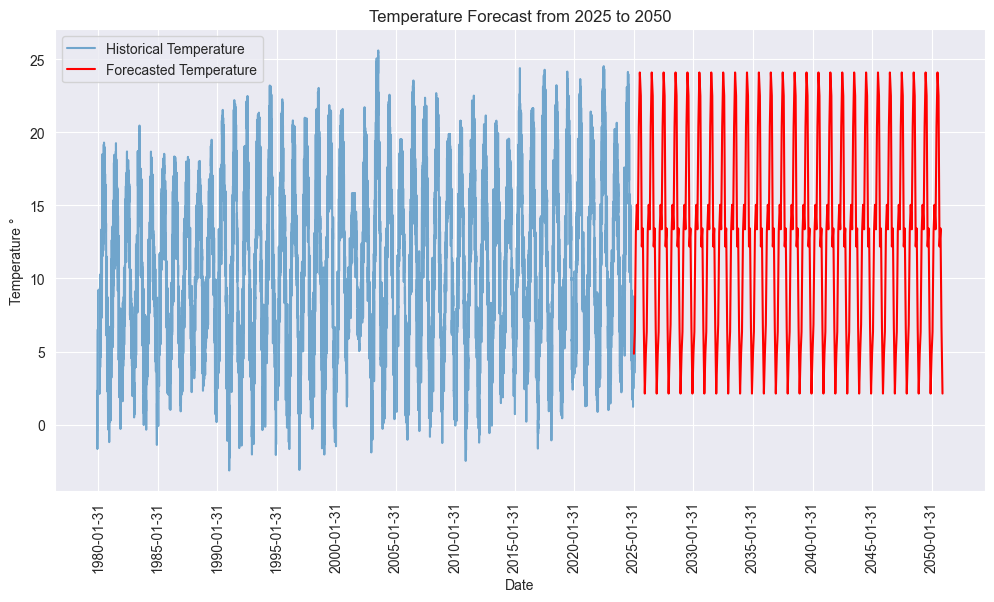

Test MSE: 5.1108187949737305


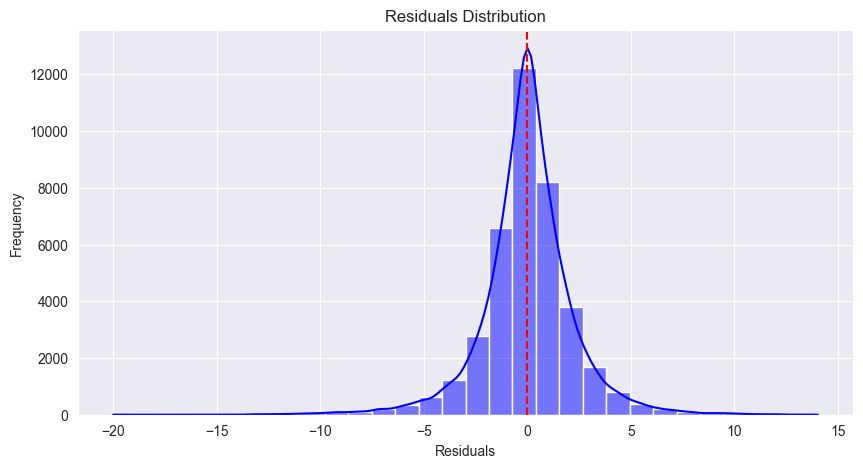

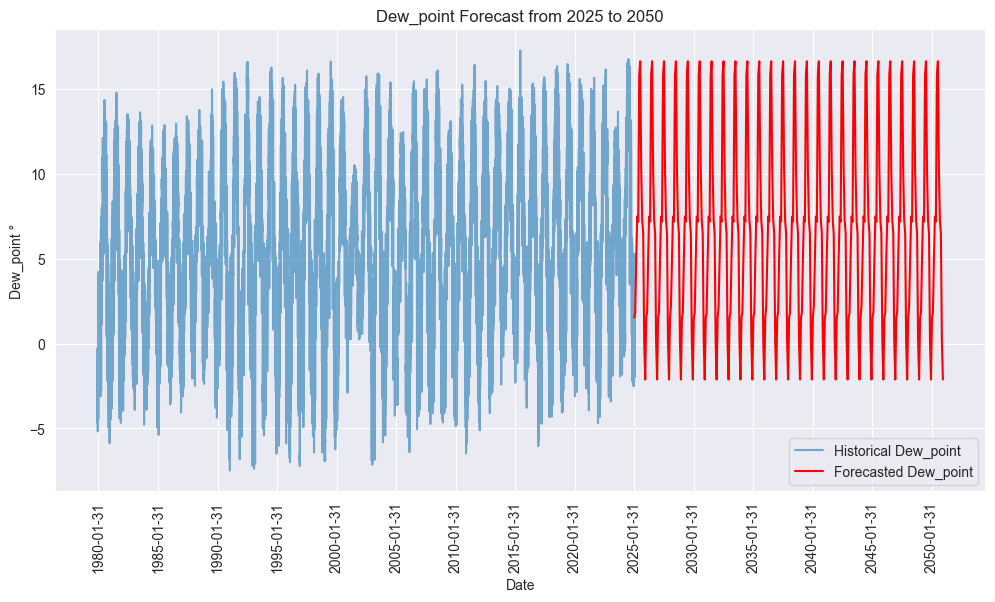

Test MSE: 84.33604335275064


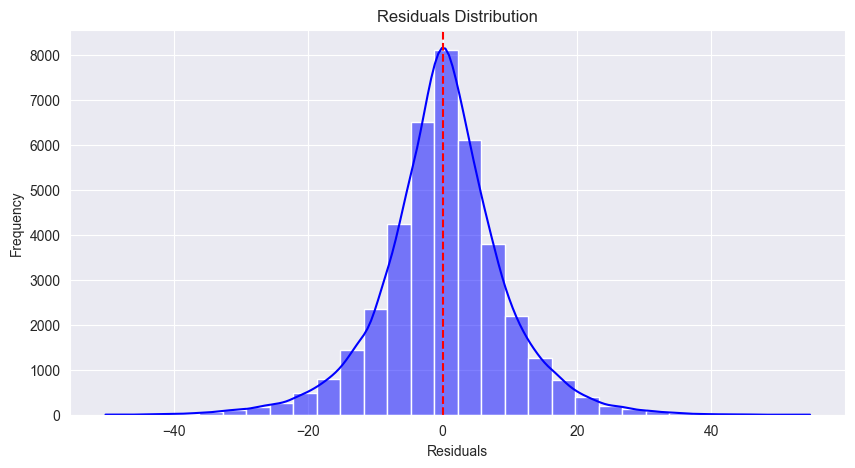

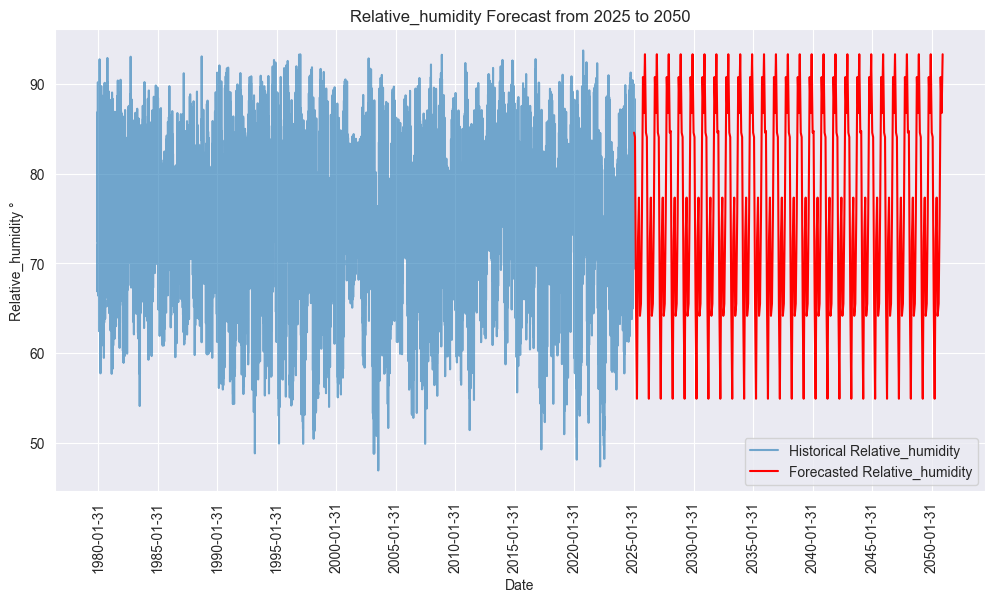

Test MSE: 3240.2881217279237


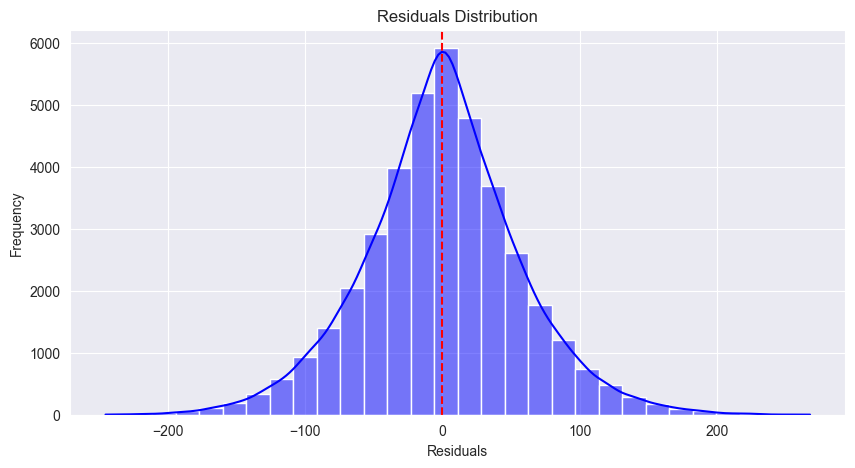

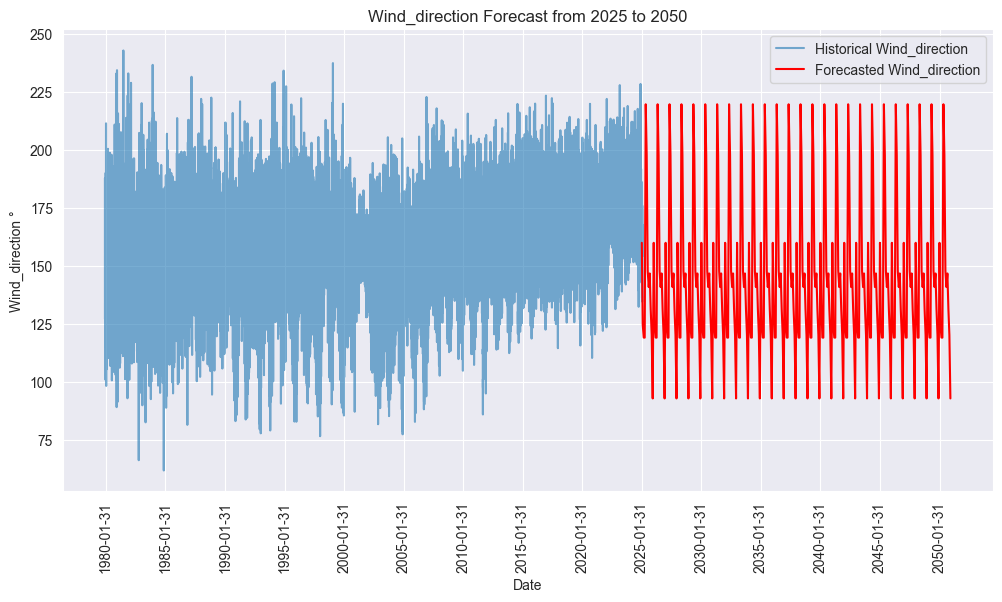

In [31]:
df = pd.read_csv("dataset-for-ML.csv")
df = df[df["elevation_group"] == "H3"]
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["day"] = df["timestamp"].dt.day
df["year"] = df["timestamp"].dt.year

features = ["station", "lon", "lat", "elevation", "region", "elevation_group", "day", "month", "year", "season"]

for target in ["temperature", "dew_point", "relative_humidity", "wind_direction"]:
    
    df['station'] = df['station'].astype('category').cat.codes
    df['region'] = df['region'].astype('category').cat.codes
    df['season'] = df['season'].astype('category').cat.codes
    df['elevation_group'] = df['elevation_group'].astype('category').cat.codes
    
    df["day"] = df["day"].astype(int)
    df['month'] = df['month'].astype(int)
    df["year"] = df["year"].astype(int)
    
    
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=177)
    
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=177, max_depth=16)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    
    forecast_dates = pd.date_range(start="2024-06-26", end="2050-12-31", freq="ME")
    all_last_six = None
    features_target = features + [target]
    for station in df["station"].unique():
        last_six = df[(df["year"] < 2025) & (df["station"] == station)].groupby(["year", "month", "day"]).mean().tail(6).reset_index()
        last_six = last_six[features_target].reset_index()
        last_six.drop("index", axis=1, inplace=True)
        if all_last_six is not None:
            all_last_six =pd.concat([all_last_six, last_six], ignore_index=True)
        else:
            all_last_six = last_six.copy()
            
    all_last_six = all_last_six[features_target]
    forecast_df = all_last_six.copy()
    
    for forecast_date in forecast_dates:
        
        new_row = {
            "station": 35,
            "lat": 45.198998036615414,
            "lon": 6.589059671118004,
            'elevation': 600,
            "elevation_group": 3,
            'region': 0,   
            "year": forecast_date.year,
            "month": forecast_date.month,
            "day": forecast_date.day,
            'season': season_mapping_forecast[forecast_date.month]
        }
        
        # Current station for current date
        new_row_df = pd.DataFrame(new_row, index=[forecast_date])
        X_new_value_for_station = new_row_df[features]
    
        temp_pred_for_station = model.predict(X_new_value_for_station)[0]
        
        new_row[target] = temp_pred_for_station
        new_row_df = pd.DataFrame(new_row, index=[forecast_date])
        forecast_df = pd.concat([forecast_df, new_row_df], ignore_index=True)
        
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=30, kde=True, color="blue")
    plt.axvline(0, color='red', linestyle='dashed')  
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residuals Distribution")
    plt.show()
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    
    plt.figure(figsize=(12,6))
    plt.plot(df["timestamp"].unique(), df.groupby(["year", "month", "day"]).mean()[target], label=f"Historical {target.capitalize()}", alpha=0.6)
    plt.plot(pd.date_range(start="2025-01-01", end="2050-12-31", freq="ME"), forecast_df[forecast_df['year']>2024].groupby(["year", "month", "day"]).mean()[target], label=f"Forecasted {target.capitalize()}", color="red")
    plt.xticks(pd.date_range(start="1980-01-01", end="2050-12-31", freq="ME")[::60], rotation=90)
    plt.xlabel("Date")
    plt.ylabel(f"{target.capitalize()} °")
    plt.title(f"{target.capitalize()} Forecast from 2025 to 2050")
    plt.legend()
    plt.show()

    forecast_df[forecast_df['year']>2024].to_csv(f"maurienne-{target}-predicted.csv", index=False)

# Dataset for Foundry

In [89]:
season_mapping_with_months = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Autumn', 'October': 'Autumn', 'November': 'Autumn'
}

season_mapping_cat = {
    3: 'Winter',
    1: 'Spring', 
    2: 'Summer',
    0: 'Autumn'
}

month_mapping_cat = {
    12: 'December', 1: 'January', 2: 'February',
    3: 'March', 4: 'April',  5: 'May',
    6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November'
}

month_mapping_reverse = {
    'December': 12, 'January': 1, 'February': 2,
    'March': 3, 'April': 4, 'May': 5,
    'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11
}

In [88]:
current_wdir = os.path.join(os.getcwd(), "predictions", "Susa")
susa_df = pd.read_csv(os.path.join(current_wdir, os.listdir(current_wdir)[0]), engine="c")
for file in os.listdir(current_wdir)[1:]:
    df = pd.read_csv(os.path.join(current_wdir, file), engine="c")
    col_to_add = list(set(df.columns.to_list()).difference(set(susa_df.columns.to_list())))[0]
    susa_df[col_to_add] = df[col_to_add]
susa_df["station"] = "SUSA"
susa_df["station"] = "MAURIENNE"
susa_df["region"] = "S"
susa_df["elevation_group"] = "H3"
susa_df["season"] = susa_df["season"].map(season_mapping_cat)
susa_df["month"] = susa_df["month"].map(month_mapping_cat)

current_wdir = os.path.join(os.getcwd(), "predictions", "Maurienne")
maurienne_df = pd.read_csv(os.path.join(current_wdir, os.listdir(current_wdir)[0]), engine="c")
for file in os.listdir(current_wdir)[1:]:
    df = pd.read_csv(os.path.join(current_wdir, file), engine="c")
    col_to_add = list(set(df.columns.to_list()).difference(set(maurienne_df.columns.to_list())))
    maurienne_df[col_to_add] = df[col_to_add]
maurienne_df["station"] = "MAURIENNE"
maurienne_df["region"] = "S"
maurienne_df["elevation_group"] = "H3"
maurienne_df["season"] = maurienne_df["season"].map(season_mapping_cat)
maurienne_df["month"] = maurienne_df["month"].map(month_mapping_cat)

In [90]:
ensamble_df = pd.read_csv("final_dataset-01-03-25.csv")
ensamble_df = ensamble_df[["lat", "lon", "elevation", "temperature", "dew_point", "relative_humidity", "wind_direction", "station", "month", "year"]]

ensamble_df = ensamble_df.groupby(["station", "month", "year"]).mean().reset_index()
ensamble_df["day"] = 15
ensamble_df = ensamble_df[ensamble_df["year"] <= 2024]

ensamble_df['region'] = ensamble_df.apply(lambda row: assign_location_region(row['lat'], row['lon']), axis=1)
ensamble_df["elevation_group"] = ensamble_df.apply(lambda row: assign_elevation_group(row['elevation'], row["region"]), axis=1)

ensamble_df['season'] = ensamble_df["month"].map(season_mapping_with_months)

ensamble_df = pd.concat([ensamble_df, susa_df], ignore_index=True)
ensamble_df = pd.concat([ensamble_df, maurienne_df], ignore_index=True)


ensamble_df['month'] = ensamble_df["month"].map(month_mapping_reverse)
ensamble_df["timestamp"] = pd.to_datetime(ensamble_df[['year', 'month', 'day']])
ensamble_df['month'] = ensamble_df["month"].map(month_mapping_cat)

import uuid
ensamble_df.loc[:, 'primary_key'] = ensamble_df.apply(lambda row: str(uuid.uuid4()), axis=1)
ensamble_df.to_csv("palantir-dataset.csv", index=False)
ensamble_df

station      month  year        lat       lon  elevation  \
0           EDDM      April  1980  48.358300  11.80920   136.2456   
1           EDDM      April  1981  48.358300  11.80920   136.2456   
2           EDDM      April  1982  48.358300  11.80920   136.2456   
3           EDDM      April  1983  48.358300  11.80920   136.2456   
4           EDDM      April  1984  48.358300  11.80920   136.2456   
...          ...        ...   ...        ...       ...        ...   
30859  MAURIENNE     August  2050  45.198998   6.58906   600.0000   
30860  MAURIENNE  September  2050  45.198998   6.58906   600.0000   
30861  MAURIENNE    October  2050  45.198998   6.58906   600.0000   
30862  MAURIENNE   November  2050  45.198998   6.58906   600.0000   
30863  MAURIENNE   December  2050  45.198998   6.58906   600.0000   

       temperature  dew_point  relative_humidity  wind_direction  day region  \
0         4.645747  33.505593          78.950255      206.325434   15     NE   
1         8.284931  34.889672          66.129328      154.510148   15     NE   
2         5.839799  31.033842          66.600734      200.361660   15     NE   
3         8.947727  39.814232          75.554781      193.713201   15     NE   
4         5.950760  32.112474          70.540681      168.452459   15     NE   
...            ...        ...                ...             ...  ...    ...   
30859    22.495075  10.212605          65.509064      140.913391   31      S   
30860    12.190645   7.290113          75.476196      146.780594   30      S   
30861    13.424442   6.475634          90.771004      131.362457   31      S   
30862     6.645339   0.139571          86.757561      120.249565   30      S   
30863     2.126432  -2.117375          93.313766       92.936256   31      S   

      elevation_group  season  timestamp                           primary_key  
0                  H0  Spring 1980-04-15  06990ea1-80c2-4b86-9603-ad34c4a304f2  
1                  H0  Spring 1981-04-15  099ca276-2b99-42ec-ab1d-e79469fc1102  
2                  H0  Spring 1982-04-15  7f50e955-fc9d-484f-95f9-eaaac231eba3  
3                  H0  Spring 1983-04-15  d81bdcb8-1184-4068-a31c-445f85bc2119  
4                  H0  Spring 1984-04-15  be02b6b5-73a4-4729-90eb-688ea522369b  
...               ...     ...        ...                                   ...  
30859              H3  Summer 2050-08-31  15099bd3-b703-4a7f-8acc-957668b297ab  
30860              H3  Autumn 2050-09-30  79ad843f-3529-45a0-b990-2cf7740647b5  
30861              H3  Autumn 2050-10-31  4f4e8ad0-c048-47cd-8391-c9c73d8cafca  
30862              H3  Autumn 2050-11-30  dd2c1e27-c031-4922-8b62-b63183b536bb  
30863              H3  Winter 2050-12-31  708521e1-5afe-46cb-b668-48c160e2ecd2  

[30864 rows x 16 columns]